# N006 ベジエ曲線のあてはめ

In [14]:
import sys,os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import numpy as np
import matplotlib.pyplot as plt
import cv2
import platform

# from sympy import *
from sympy import diff,Symbol,Matrix,symbols,solve,simplify,binomial,lambdify
from sympy.abc import a,b,c
# init_session()
from sympy import var
# px,py =var('px:4'),var('py:4')

# Google Colaboratory の MyDrive パス
COLABRDROOT = "/content/drive/MyDrive/RadiShLab"

# ホーム
LOCALHOME = "."  # フォルダを絶対指定するならここを書き変えてください

# 環境判定（Google Colaboratory かどうかの判定）
try:
    from google.colab import drive
    drive.mount('/content/drive')
    sys.path.append(COLABRDROOT+'/rdlib')
    COLABORATORY = True
except ImportError:
    sys.path.append('./rdlib')
    COLABORATORY = False
    if platform.system()=='Windows':
        os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
import rdlib8 as rd

# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME
resdir = "/res/windows" if platform.system() == "Windows" else "/res"

NSilF = labhome+'/RDSamples/NSilImages' # 正規化されたシルエット画像のフォルダ
imgs = rd.collectimages(NSilF)       # シルエット画像のリスト

In [ ]:
# 画像の左右の輪郭線を抽出　（N005参照）
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
canvas = cv2.cvtColor(np.zeros_like(img) ,cv2.COLOR_GRAY2BGR)
rd.drawContours(canvas,conLeft,color=(0,255,0),thickness=2)
rd.drawContours(canvas,conRight,color=(0,255,255),thickness=2)
plt.figure(dpi=100)
rd.plotimg(canvas)
print("輪郭線の画素数は、左 {}  右{}".format(len(conLeft),len(conRight)))

輪郭線を構成する画素の数は、この例で左右それぞれ300画素近い。

## **getSamples()**
> **rd.getSamples(cont,N=20,mode='Equidistant')**  
    > 入力  
    > 　**cont** 輪郭線構造体 開いた輪郭線を想定している  
    > 　**N** サンプル数  
    > パラメータ  
    >　 **mode = 'Equidistant'**  始点からの距離について等間隔 (default)  
    > 　**mode = 'Simple'**  単純にインデックスを等間隔

ディジタル画像は斜め方向と上下左右とで画素間の距離が異なるので、単純にインデックスを等間隔に刻むと、輪郭が斜めになっている部分と縦横に伸びている部分とでサンプリング間隔が変化してしまう。

曲線あてはめにはそれほど影響しないが、気にする場合は **Equidistant**を用いるとよい。

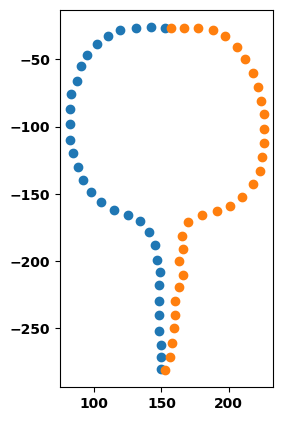

In [3]:
Left = rd.getSamples(conLeft,N=32,mode='Equidistant')
Right = rd.getSamples(conRight,N=32,mode='Simple')

plt.figure(figsize=(5,5),dpi=100)
g = plt.subplot()
g.set_aspect('equal')
plt.scatter(Left[:,0],-Left[:,1])
plt.scatter(Right[:,0],-Right[:,1]);

左が距離等間隔、右がインデックスの等間隔

# ベジエ曲線のあてはめ

- 標本点 $samples[i]$ と同じ数だけの点をベジエ曲線上に設定し、たがいを紐づける。ベジエ曲線上の点$P[i]$はパラメータ $t[i]$ だけで特定される。つまり、$P[i]=Bez(t[i])$ と書ける。
- 目的関数を$\|samples[i]-Bez[t[i]]\|$とし、これを最小化するような 関数$Bez()$を見つけることが目的である。
- ベジエ曲線は$N+1$個の制御点で規定されるので、もし $t[i]$ が既知であるならば、未知数　$2(N+1)$個 の最適化問題である。しかし、実際には $t[i]$ はわからない。
- 逆にベジエ曲線の制御点が分かっているならば、未知数は $t[i]$ であり、ベジエ曲線上で各標本点の最寄りの点を探す問題となる。
- 実際にはいずれも未知であるのですべて連立させて最適化しないといけないが一度に求める解析的な方法はありそうにない。そこで、ここでは緩和法的なアルゴリズムを用いて解決する。

### 漸近的ベジエフィッティングアルゴリズム

> **fit0()**  
> パラメータを固定して評価関数が最小化されるような制御点を求めることで、暫定的なベジエ近似曲線の表現式を得るプログラム   

> **fit1()**  
> fit0() と refineTparaN() を繰り返すことでフィッティングを行うプログラム。

> **fit1T()**
> fit1() の tensorflow による実装

> **fit2()**   
> 十分近似がうまくいくまで、次数を段階的に増やしていくプログラム

>> mode 0    fit1
>> mode 1    fitT1 mode 1
>> mode 2    fitT1 mode 0 

以上の関数を持つクラス、BezierCurve を用意した。

---

## class BezierCurve:
> クラス変数  
>> **driftThres** = 0.03 # 繰り返しの終了を決定するパラメータ変動幅の平均値に対するしきい値  
>> **errorThres** = 0.01  # 繰り返しの終了を決定するエラー変動のしきい値  
>> **dCount** = 5        # ２分探索の打ち切り回数  
>> **debugmode** = False  # デバッグ情報の表示オンオフ  
>> **openmode** = False  # 端点をサンプルに強制吸着するか否か  
>> **AsymptoticPriority** = 'distance' # パラメータ割り当てのフェーズで距離（'distance'）を尺度とするか、等間隔配置（'span'）を評価尺度とするか

## **BezierCurve()**　（コンストラクタ）
> **rd.BezierCurve(self, N=5, samples = [], initialPara=[])**  
>入力
>>    **samples**   輪郭の標本  
>>    **N**  ベジエ曲線の次数  
>>    **initialPara**   サンプルに対するベジエ関数のパラメータの初期値
>>                  デフォルトは[]であり、その場合は初期値はリニアとなる
    
> **bez = BezierCurve(N=5,con)**

## **bez.fit0()**  高速あてはめ
> **bez.fit0(tpara=[])**  
> 入力  
>>   **tpara** = []  初期パラメータ

> 出力  
>>   **cps** 制御点のリスト  
>>   **func** ベジエ曲線の式（Matrix([Xの式,yの式]))

> 動作説明  
>> 標本点に対応するベジエ曲線上の対応点のパラメータがパラメータ空間で等間隔であると仮定してあてはめを実行する。繰り返しをしないので高速。

##  **bez.fit1()**　厳密あてはめ
> **bez.fit1(maxTry=0,withErr=False)**  
> パラメータ
>> **maxTry** 最大繰り返し回数　0の場合は収束条件を満たすまで繰り返す   
>> **withErr**  誤差の平均値を返すかどうかの真理値

> 出力  
>> withErrが真のとき　→  cps, func     (fit0と同じ）  
>> withErrが偽のとき　→  error, func, error(あてはめ誤差の平均値） 

> 動作説明  次の２つのステップをエラーが閾値以下になるか、繰り返し回数が maxTry になるまで繰り返す
>> Step1  fit0() の実行      
>> Setp2  fit0()で求めた曲線をもとに、標本点に対応するパラメータを再計算する  
>>（前回の仮のパラメータが示す位置よりもより近い曲線上の点を見つけ、紐づけるパラメータを更新する）


##  **bez.fit1T()**　厳密あてはめ　Tensorflow版
> **bez.fit1T(maxTry=0,withErr=False, tpara=[], lr=0.005, mode=1)**  
> パラメータ
>> **maxTry** 最大繰り返し回数　0の場合は収束条件を満たすまで繰り返す   
>> **withErr**  誤差の平均値を返すかどうかの真理値
>> **tpara** ベジエパラメータの初期値　（なければ等間隔）
>> **lr** Adam オプティマイザーの学習係数

> 出力  
>> withErrが真のとき　→  cps, func     (fit0と同じ）  
>> withErrが偽のとき　→  error, func, error(あてはめ誤差の平均値） 

> 動作説明（mode 0）　次の２つのステップを繰り返す
>> Step1  fit0() の実行
>> Setp2  曲線を固定しておき、パラメータに対応する座標とサンプル点の誤差が小さくなるように、パラメータの値を更新する。（tensorflowによる誤差逆伝搬法）

> 動作説明（mode 1）　次のステップを繰り返す
>> サンプル点とパラメータにより指定されるベジエ曲線上の点との距離が最小化されるように、制御点とパラメータとを同時に誤差逆伝搬法により更新する。（tensorflowによる誤差逆伝搬法）

##  **bez.fit2()**   段階的あてはめ
> **bez.fit2(Nfrom=3,Nto=12,maxTry=3,mode=0, prefunc = None,errorThres=0.75, tpara=[],withErr=False, withFig)**

> パラメータ
>> **Nfrom**,**Nto**,   # 近似次数の開始値と終了値
>> **prefunc**,  # 関数の初期値

>> **maxTry** 最大繰り返し回数　0の場合は収束条件を満たすまで繰り返す   
>> **withErr**  誤差の平均値を返すかどうかの真理値
>> **errorThres**  当てはめ誤差によるくりかえし停止しきい値
>> **tpara** ベジエパラメータの初期値　（なければ等間隔）
>> **withErr**　 停止次数と誤差値を返すかどうか
>> **withFig**  画像出力する次数のリスト

>> mode 0    fit1()
>> mode 1    fitT1(mode=1)
>> mode 2    fitT1(mode=0)

> 出力  
>> withErrが真のとき　→  cps, func     (fit0と同じ）  
>> withErrが偽のとき　→  Nlast 収束時の次数, dict{N：(cps,func,err)} 

> 動作説明  
>>   あてはめ次数を Nfrom からは始めて、最大 Nto まで fit1(maxTry) を繰り返す  
>>   ただし、平均あてはめ誤差が errorThres で指定した値より小さくなれは停止

> 出力  
>> withErrが真のとき　→  cps, func     (fit0と同じ）  
>> withErrが偽のとき　→  Nlast 収束時の次数, dict{N：(cps,func,err)} 

> 動作説明  
>>   あてはめ次数を Nfrom からは始めて、最大 Nto まで fit1(maxTry) を繰り返す  
>>   ただし、平均あてはめ誤差が errorThres で指定した値より小さくなれは停止

## **toggledebugmode(set=True,debug=False)**   デバッグ情報のオンオフ
>>  **set** True/セットする、False/トグルする  
>>  **debug** True/誤差表示あり、False/誤差表示なし

## **setParameters()**  
>**setParameters(driftThres=0.03,errorThres=0.01,dCount=5,debugmode=False,openmode=False)**  パラメータの表示とセット

> クラス変数
>>**driftThres** = 0.03 # 繰り返しにおけるパラメータ変動幅の平均値に対するしきい値。  
>>**errorThres** = 0.01 # 繰り返し打ち切りを決める変動幅のしきい値。 
     パラメータと誤差の変動幅がともにしきい値より小さくなったら計算を打ち切る。



lengths = [10,12,21,23,24,32,34,35,40,41,42,51]
searchfor = [10,20,30,40,50]
# 結果の描画

##  **drawBez()**
> **rd.drawBez(rdimg,bezL=None,bezR=None,bezC=None,cpl=None,cpr=None,cpc=None, 
             cntL=[],cntR=[],cntC=None, ladder=None,PosL=[],PosR=[],PosC=[],n_samples=20,saveImage=False,savepath="",ct=[])**
             
>入力  
>>    **rdimg**  シルエット画像  
>>    **bezL**,**bezR**,**bezC**   ベジエ曲線の定義式　3本まで描ける  
>>    **cpl**,**cpr**,**cpc**     ベジエ曲線の制御点    
>>    **cntL**,**cntR**,**cntC**  標本点
>>    **PosL**,**PosR**.**PosC** ラダーの設置点
>パラメータ  
>>    **ladder**  標本点間を結ぶ線分を描画するかどうか    
>>    **n_samples**  ラダーの数  
>>    **saveImage** 画像を保存するかどうか  
>>    **savepath** ファイル名  
>>    **ct** カラー指定　説明省略
    

# 実行例

### 現在のパラメータ設定の表示

In [4]:
rd.BezierCurve.setParameters()

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0



## 高速フィッテイング fit0()の実行例 
 4次ベジエ近似、not openmode ( 端点固定 ）

Wall time: 572 ms


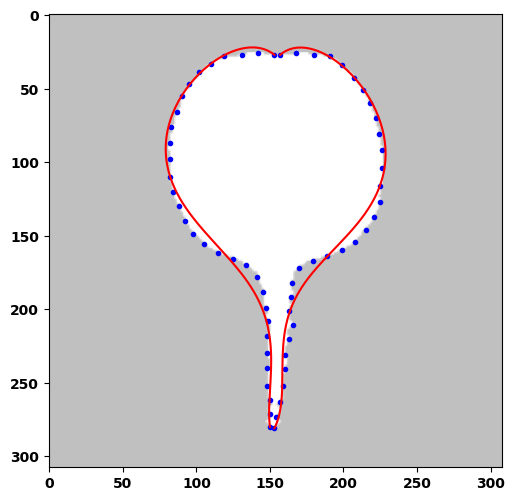

In [5]:
%%time
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
cntL = rd.getSamples(conLeft,N=32)
cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
bezL = rd.BezierCurve(N=5,samples=cntL)
bezR = rd.BezierCurve(N=5,samples=cntR)
# rd.BezierCurve.toggledebugmode(set=True,debug=True)
# 高速あてはめの実行
cpsL0,fL0 = bezL.fit0()
cpsR0,fR0 = bezR.fit0()
# 結果の描画
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL0,bezR=fR0,cntL=cntL,cntR=cntR)

## 得られたベジエ曲線の定義式

In [6]:
fL0,fR0

(Matrix([
 [150.0*t**5 + 142.042330369017*t**4*(5 - 5*t) + 2137.60197239756*t**3*(1 - t)**2 - 462.385837532459*t**2*(1 - t)**3 + 494.598981039158*t*(1 - t)**4 + 153.0*(1 - t)**5],
 [  280.0*t**5 + 221.554435036425*t**4*(5 - 5*t) + 1169.81592950348*t**3*(1 - t)**2 + 1976.75966247282*t**2*(1 - t)**3 - 79.754038022581*t*(1 - t)**4 + 27.0*(1 - t)**5]]),
 Matrix([
 [153.0*t**5 + 181.598415830238*t**4*(5 - 5*t) + 752.415341989178*t**3*(1 - t)**2 + 3592.62501654297*t**2*(1 - t)**3 + 1048.52939269959*t*(1 - t)**4 + 157.0*(1 - t)**5],
 [ 281.0*t**5 + 225.438714509134*t**4*(5 - 5*t) + 1093.80753914332*t**3*(1 - t)**2 + 2206.66340490188*t**2*(1 - t)**3 - 88.8752513013393*t*(1 - t)**4 + 27.0*(1 - t)**5]]))

この式は sympy 形式で表現されており、次のような方法でパラメータ t に値を代入することができます。

In [7]:
fL0.subs('t',0.5)  # fL の t に 0.5 を代入　（左輪郭の中間点の座標） 

Matrix([
[99.4695864921669],
[140.049804035495]])

sympy は数式処理ライブラリですので、具体値だけでなく、次のように式を代入することも可能です。

In [8]:
a,b = var('a,b')
fL0.subs('t',(a+b)**2).subs(a,3)  # t に a+b を代入し、さらに a に３を代入

Matrix([
[153.0*(1 - (b + 3)**2)**5 + 494.598981039158*(1 - (b + 3)**2)**4*(b + 3)**2 - 462.385837532459*(1 - (b + 3)**2)**3*(b + 3)**4 + 2137.60197239756*(1 - (b + 3)**2)**2*(b + 3)**6 + 142.042330369017*(5 - 5*(b + 3)**2)*(b + 3)**8 + 150.0*(b + 3)**10],
[  27.0*(1 - (b + 3)**2)**5 - 79.754038022581*(1 - (b + 3)**2)**4*(b + 3)**2 + 1976.75966247282*(1 - (b + 3)**2)**3*(b + 3)**4 + 1169.81592950348*(1 - (b + 3)**2)**2*(b + 3)**6 + 221.554435036425*(5 - 5*(b + 3)**2)*(b + 3)**8 + 280.0*(b + 3)**10]])

sympy の代入 subs は元の式に影響を与えません

In [9]:
fL0 # 代入前の式のままであることを確認せよ

Matrix([
[150.0*t**5 + 142.042330369017*t**4*(5 - 5*t) + 2137.60197239756*t**3*(1 - t)**2 - 462.385837532459*t**2*(1 - t)**3 + 494.598981039158*t*(1 - t)**4 + 153.0*(1 - t)**5],
[  280.0*t**5 + 221.554435036425*t**4*(5 - 5*t) + 1169.81592950348*t**3*(1 - t)**2 + 1976.75966247282*t**2*(1 - t)**3 - 79.754038022581*t*(1 - t)**4 + 27.0*(1 - t)**5]])

## 制御点の位置

In [10]:
cpsL0,cpsR0

([[153.0, 27.0],
  [98.91979620783161, -15.950807604516198],
  [-46.238583753245905, 197.67596624728174],
  [213.76019723975574, 116.98159295034813],
  [142.04233036901692, 221.55443503642496],
  [150.0, 280.0]],
 [[157.0, 27.0],
  [209.70587853991887, -17.77505026026786],
  [359.2625016542971, 220.66634049018842],
  [75.2415341989178, 109.3807539143325],
  [181.59841583023803, 225.43871450913443],
  [153.0, 281.0]])

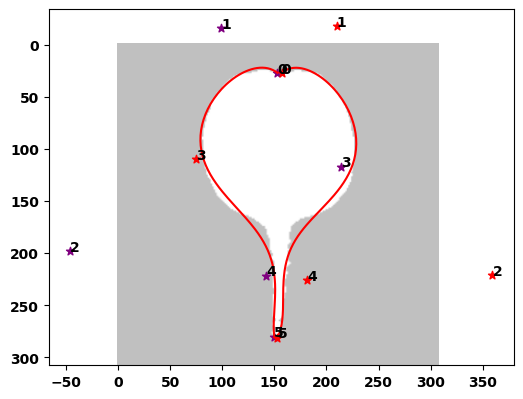

In [11]:
rd.drawBez(img,stt=0.00,end=1.0,bezL=fL0,bezR=fR0,cpl=cpsL0,cpr=cpsR0)

# Eager フィッティング fit1()の実行例
　４次近似  not openmode ( 端点固定 ）

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

....................................................................................................
.....................E

....................................................................................................
..........................................................E

Wall time: 1min 17s


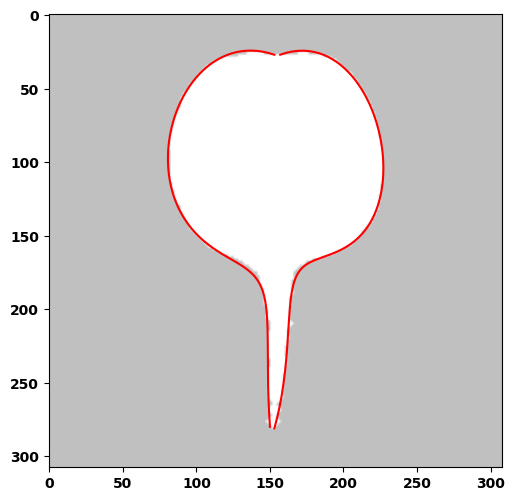

In [12]:
%%time
rd.BezierCurve.setParameters(openmode=False)
bezL = rd.BezierCurve(N=5,samples=cntL)
bezR = rd.BezierCurve(N=5,samples=cntR)
# rd.BezierCurve.toggledebugmode(set=True,debug=True)
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
# cntL = rd.getSamples(conLeft,N=32)
# cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
# bezLN = rd.BezierCurve(N=4,samples=cntL)
# bezRN = rd.BezierCurve(N=4,samples=cntR)
# ここまでは先と同じなので2度実行する必要がない
# Eagerあてはめ
rd.BezierCurve.AsymptoticPriority = 'distance'
cpsL1,fL1 = bezL.fit1()
cpsR1,fR1 = bezR.fit1()
# 結果の描画
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL1,bezR=fR1)

# temsolflow版　Eager フィッティング fit1T()の実行例

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

..............................................................E

..................................................
Wall time: 18.6 s


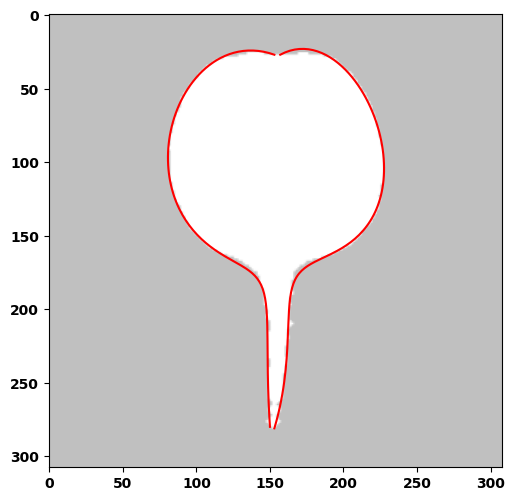

In [13]:
%%time
rd.BezierCurve.setParameters(openmode=False)
#rd.BezierCurve.toggledebugmode(set=True,debug=True)
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
# cntL = rd.getSamples(conLeft,N=32)
# cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
# bezLN = rd.BezierCurve(N=4,samples=cntL)
# bezRN = rd.BezierCurve(N=4,samples=cntR)
# ここまでは先と同じなので2度実行する必要がない
# Eagerあてはめ
bezLt = rd.BezierCurve(N=5,samples=cntL)
bezRt = rd.BezierCurve(N=5,samples=cntR)
rd.BezierCurve.AsymptoticPriority = 'distance'
cpsL1t,fL1t = bezLt.fit1T(mode=1,maxTry=50)
cpsR1t,fR1t = bezRt.fit1T(mode=1,maxTry=50)
# 結果の描画
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL1t,bezR=fR1t)

## fit0() と fit1() の結果の違い

オレンジが fit0 （高速）、グリーンが fit1() の結果。

In [14]:
[rd.n2c(int(i)) for i in "221456789"]

[(0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0),
 (1.0, 0.4980392156862745, 0.054901960784313725, 1.0),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)]

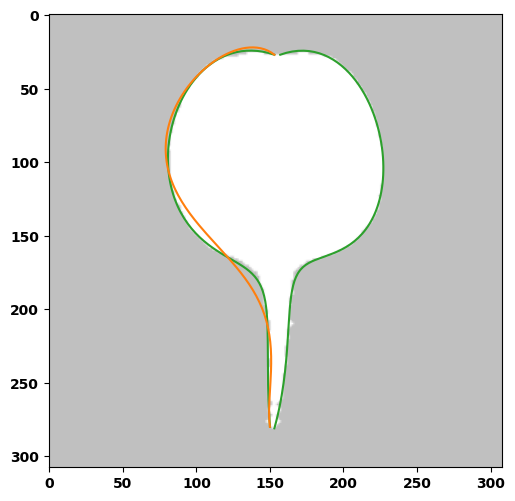

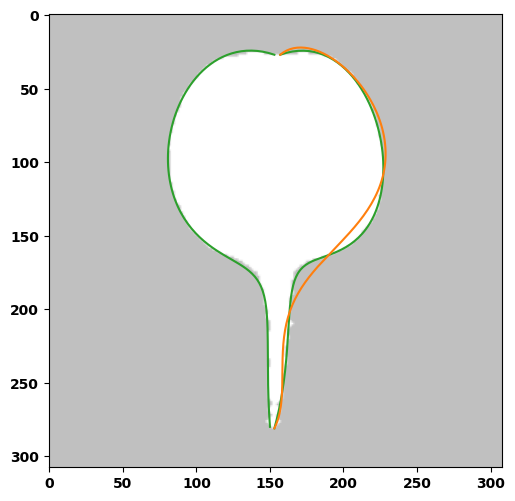

In [15]:
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL1,bezR=fR1,bezC=fL0,ct="221456789")
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL1,bezR=fR1,bezC=fR0,ct="2213456789")

この例は厳密あてはめの方が優れていることが分かりやすい。

これは次数が低いからで、経験的には近似の次数が上がると fit0 と fit1 の差は少なく、大量のデータを処理するなら fit0 でも十分だと思われる。

### 関数式の違い

In [16]:
fL0,fL1,fR0,fR1

(Matrix([
 [150.0*t**5 + 142.042330369017*t**4*(5 - 5*t) + 2137.60197239756*t**3*(1 - t)**2 - 462.385837532459*t**2*(1 - t)**3 + 494.598981039158*t*(1 - t)**4 + 153.0*(1 - t)**5],
 [  280.0*t**5 + 221.554435036425*t**4*(5 - 5*t) + 1169.81592950348*t**3*(1 - t)**2 + 1976.75966247282*t**2*(1 - t)**3 - 79.754038022581*t*(1 - t)**4 + 27.0*(1 - t)**5]]),
 Matrix([
 [150.0*t**5 + 140.562406698594*t**4*(5 - 5*t) + 1867.03808940304*t**3*(1 - t)**2 + 261.733124521598*t**2*(1 - t)**3 + 249.445684538981*t*(1 - t)**4 + 153.0*(1 - t)**5],
 [   280.0*t**5 + 148.5460229399*t**4*(5 - 5*t) + 1383.45819903354*t**3*(1 - t)**2 + 2543.45456612122*t**2*(1 - t)**3 - 41.3336195701288*t*(1 - t)**4 + 27.0*(1 - t)**5]]),
 Matrix([
 [153.0*t**5 + 181.598415830238*t**4*(5 - 5*t) + 752.415341989178*t**3*(1 - t)**2 + 3592.62501654297*t**2*(1 - t)**3 + 1048.52939269959*t*(1 - t)**4 + 157.0*(1 - t)**5],
 [ 281.0*t**5 + 225.438714509134*t**4*(5 - 5*t) + 1093.80753914332*t**3*(1 - t)**2 + 2206.66340490188*t**2*(1 - t)**

# Openmode

ベジエ曲線の性質として、曲線は必ず両端の制御点を通る。

そこで、両端の制御点はサンプルの両端であるものとして固定し、両端以外の制御点のみを未知数とすることで、未知数の数を減らしている。

しかし、データとして両端付近はイレギュラーな位置であることが多い。そこで両端を固定せずに未知数としてフィッティングを試みるのが **Openmode** である。

**Openmode** で計算させたい場合は、次のように、 **BezierCurve** のクラス変数 **openmode** の Trueをセットしてから処理を行えばよい。 

In [17]:
rd.BezierCurve.setParameters(openmode=True)

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  True
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0



....................................................................................................
......................E

....................................................................................................
.................................................................E



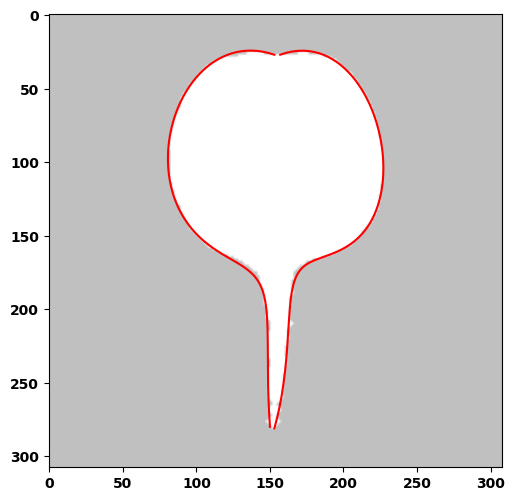

In [18]:
rd.BezierCurve.AsymptoticPriority = 'distance'
cpsL1o,fLo = bezL.fit1()
cpsR1o,fRo = bezR.fit1()
# 結果の描画
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL1,bezR=fR1)

## オープンモードと固定モードの結果比較

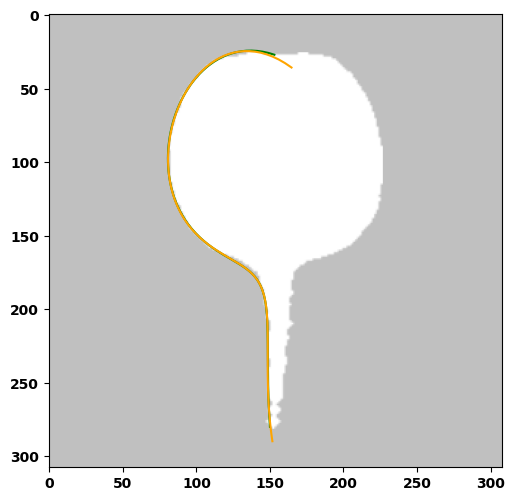

In [19]:
rd.drawBez(img,stt=0.00,end=1.00,bezL=fL1,bezR=fLo,ct=["green","orange"])

シルエットの存在する部分のフィッティング状態にはあまり違いはないように見えるが、オープンモード（オレンジ）の上端点が個体内部に回り込んでいるのがわかる。

*stt=0.0,end=1.0*はどの範囲を描くかの指定である。上下５％カットしてみると、次のようになる。

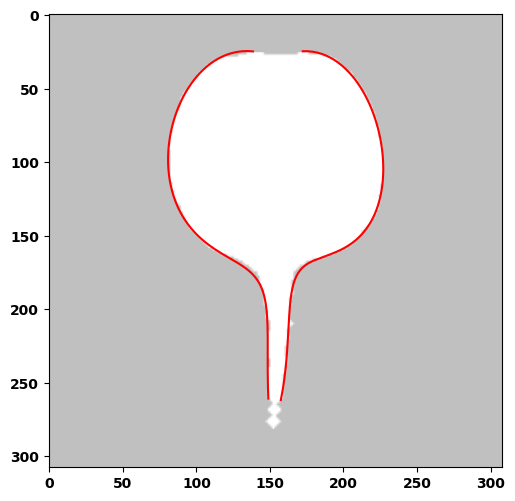

In [20]:
# 両端のカット
rd.drawBez(img,stt=0.05,end=0.95,bezL=fLo,bezR=fRo)

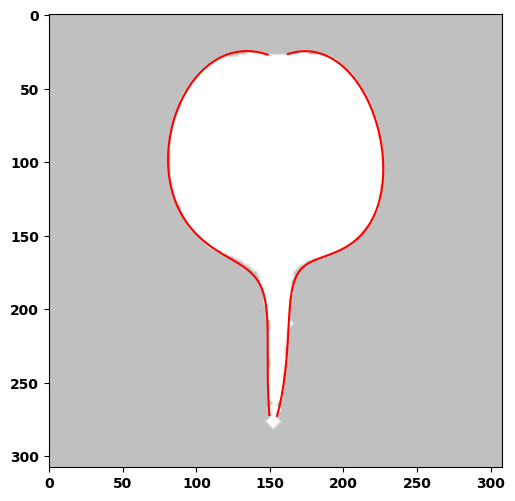

In [21]:
# 両端のカットなし
rd.drawBez(img,stt=0.03,end=0.97,bezL=fLo,bezR=fRo)

# より高次の近似　非openmode  高速　８次

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0



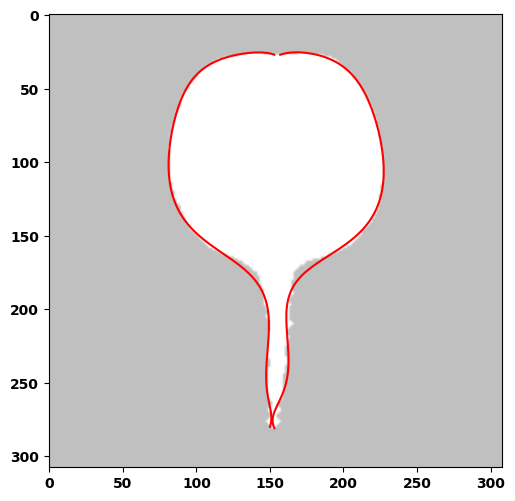

In [22]:
rd.BezierCurve.setParameters(openmode=False)
bezL8 = rd.BezierCurve(N=8,samples=cntL)
bezR8 = rd.BezierCurve(N=8,samples=cntR)
cpsL8,fL8 = bezL8.fit0()
cpsR8,fR8 = bezR8.fit0()
rd.drawBez(img,stt=0.00,end=1.00,bezL=fL8,bezR=fR8)

次数が高いと高速あてはめでも結構きれいに近似できることがわかる。

# より高次の近似　非openmode 厳密　８次

...E

............................E



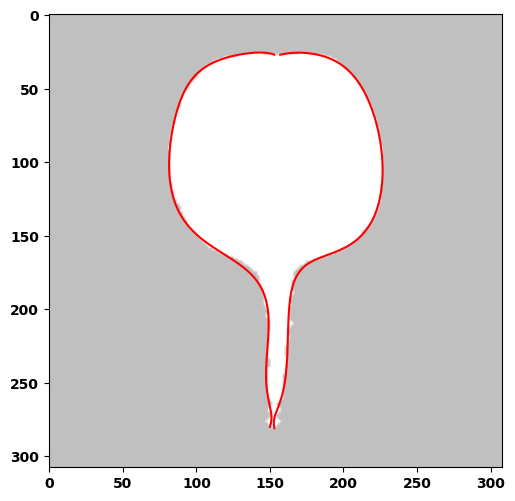

In [23]:
cpsL81,fL81 = bezL8.fit1()
cpsR81,fR81 = bezR8.fit1()
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL81,bezR=fR81)

## 非 openmode 厳密　８次 

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

...E

............................E

Wall time: 18.6 s


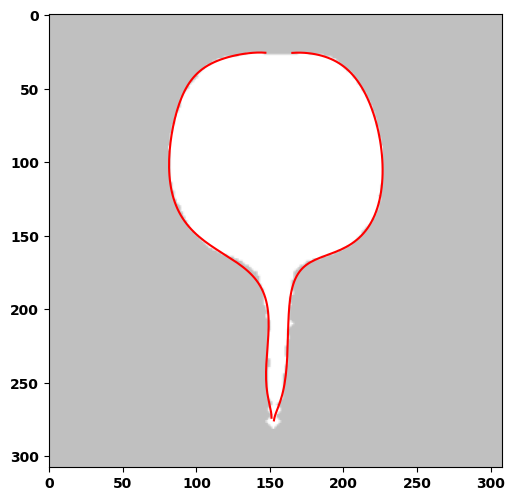

In [24]:
%%time
rd.BezierCurve.setParameters(openmode=False)
cpsL8,fL8 = bezL8.fit1()
cpsR8,fR8 = bezR8.fit1()
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL8,bezR=fR8);

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

...E

.............E

Wall time: 9.8 s


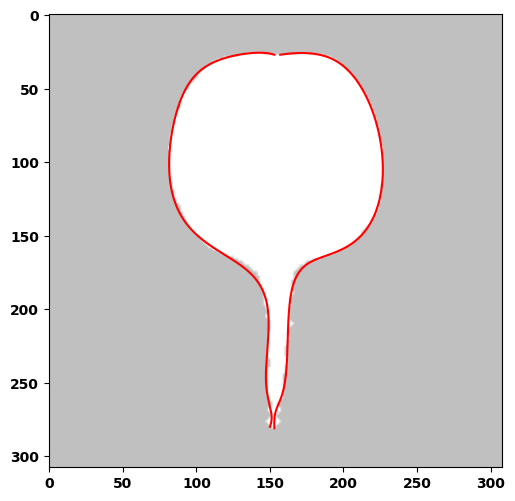

In [25]:
%%time
rd.BezierCurve.setParameters(openmode=False)
#rd.BezierCurve.toggledebugmode(set=True,debug=True)
bezL8 = rd.BezierCurve(N=8,samples=cntL)
bezR8 = rd.BezierCurve(N=8,samples=cntR)
cpsL8T,fL8T = bezL8.fit1T()
cpsR8T,fR8T = bezR8.fit1T()
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL8T,bezR=fR8T);

描き分け

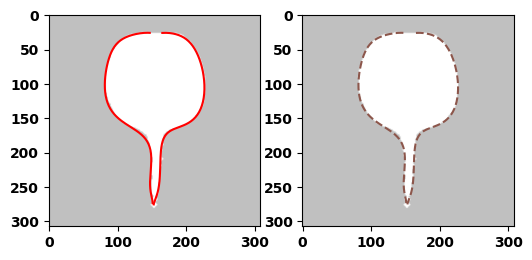

In [26]:
rd.drawBez(img,stt=0.02,end=0.98,bezL=fL8,bezR=fR8,layout=121)
rd.drawBez(img,figsize=None,ct='5550',stt=0.02,end=0.98,bezL=fL8,bezR=fR8,layout=122,linestyle='dashed')

In [2]:
def Demo(imgnum,samples=32,N=5,Amode=0,controlPoints=False):
    # 画像の左右の輪郭線を抽出　（S5参照）
    img = imgs[imgnum]
    conLeft,conRight = rd.getCntPairWithImg(img)
    print("輪郭線の画素数は、左 {}  右{}".format(len(conLeft),len(conRight)))
    Left = rd.getSamples(conLeft,N=samples,mode='Equidistant')
    Right = rd.getSamples(conRight,N=samples,mode='Equidistant')
    # 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
    # ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
    bezL = rd.BezierCurve(N=N,samples=Left)
    bezR = rd.BezierCurve(N=N,samples=Right)
    if Amode == 0:
        # 高速あてはめの実行
        cpsL,fL = bezL.fit0()
        cpsR,fR = bezR.fit0()
    else:
        cpsL,fL = bezL.fit1T()
        cpsR,fR = bezR.fit1T()
    # 結果の描画
    if controlPoints:
        rd.drawBez(img,stt=0.00,end=1.0,bezL=fL,bezR=fR,cntL=Left,cntR=Right,cpl=cpsL,cpr=cpsR)
    else:
        rd.drawBez(img,stt=0.00,end=1.0,bezL=fL,bezR=fR,cntL=Left,cntR=Right)

# fit1 のテスト

輪郭線の画素数は、左 302  右301
Wall time: 469 ms


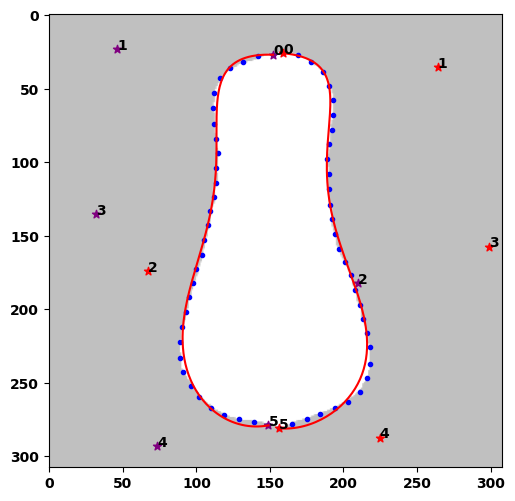

In [28]:
%%time
Demo(0,controlPoints=True)

輪郭線の画素数は、左 326  右326


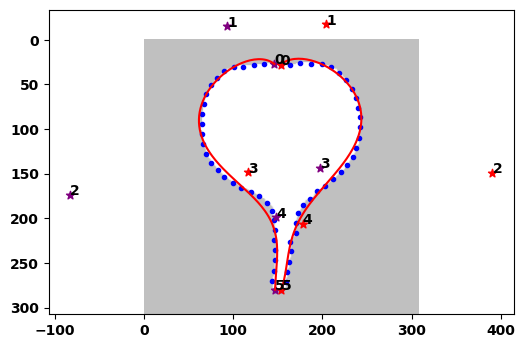

In [29]:
Demo(1,controlPoints=True)

輪郭線の画素数は、左 265  右255


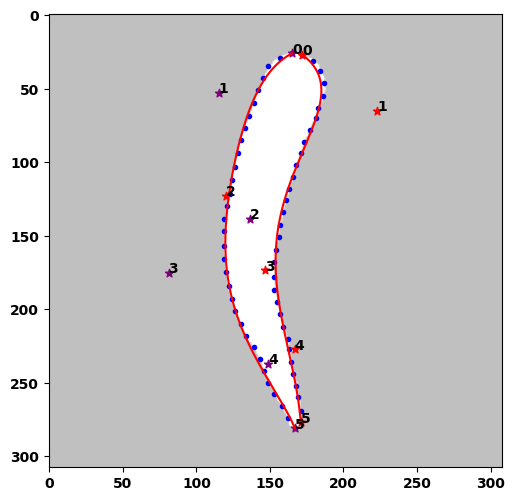

In [30]:
Demo(2,controlPoints=True)

輪郭線の画素数は、左 265  右264


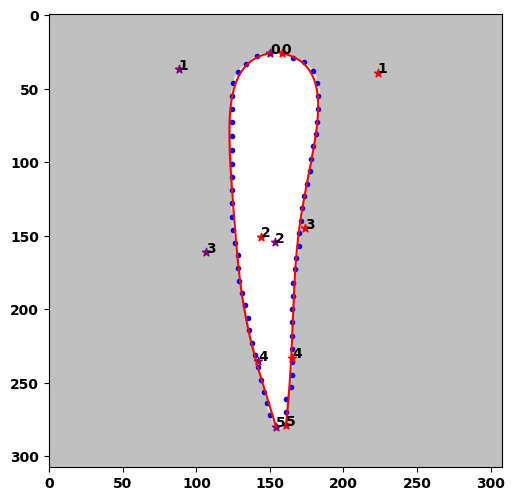

In [31]:
Demo(3,controlPoints=True)

輪郭線の画素数は、左 317  右320


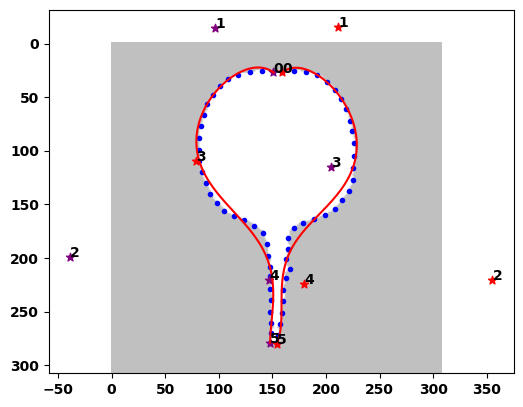

In [32]:
Demo(4,controlPoints=True)

# 8次ベジエ近似

輪郭線の画素数は、左 317  右320


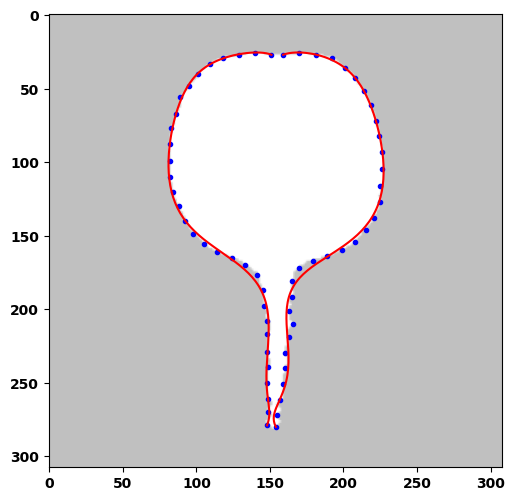

In [33]:
Demo(4,N=8)

輪郭線の画素数は、左 281  右283


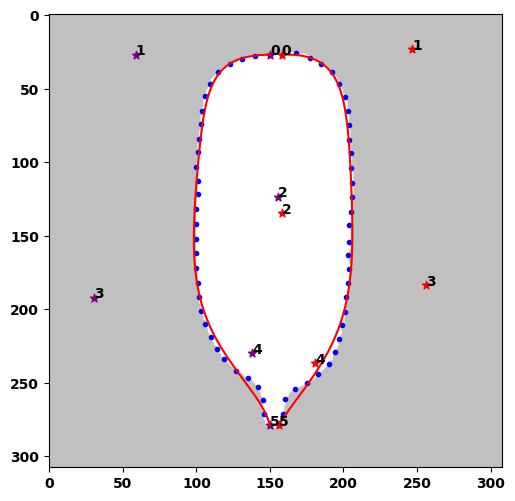

In [34]:
Demo(5,controlPoints=True) #４次

輪郭線の画素数は、左 320  右320


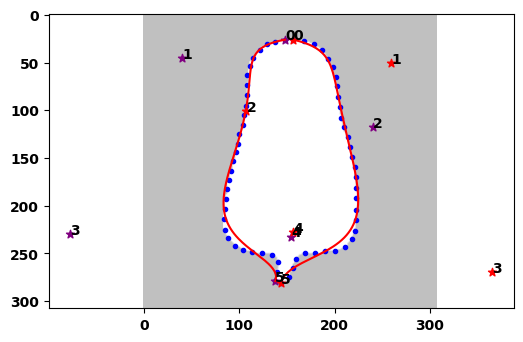

In [35]:
Demo(6,controlPoints=True) #４次

# この個体は５次ベジエの高速あてはめモードではいまいちフィッティングしない。次数を上げてやればきれいにフィッティングできる。

輪郭線の画素数は、左 320  右320


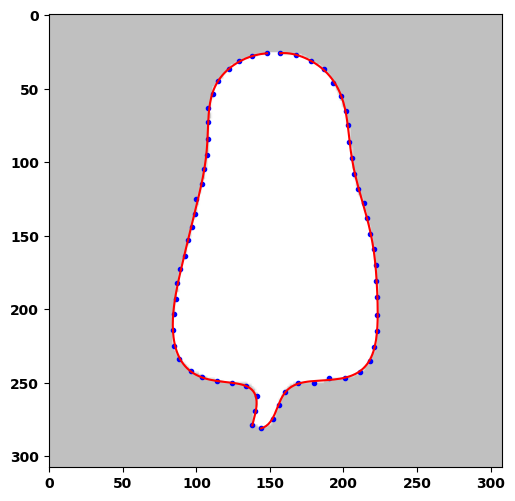

In [36]:
Demo(6,N=12) #12次

輪郭線の画素数は、左 265  右260


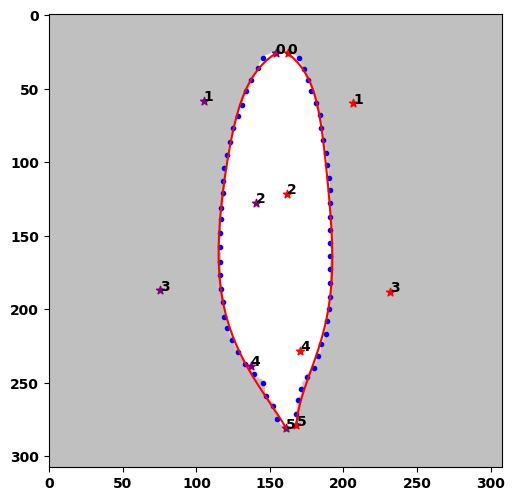

In [37]:
Demo(7,controlPoints=True) # 4次

輪郭線の画素数は、左 265  右261


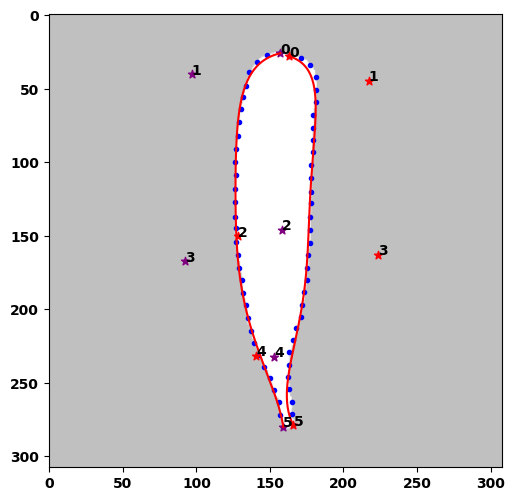

In [38]:
Demo(8,controlPoints=True) # 4次

# Eagerフィッティング (tensorflow版)

先に、ダルマ型のフィッティングで１２次を使ったが、Eagerフィッティング (fit1, fit1T) を使えば、低次でもかなりいい線までフィッティングできる。

# ５次 Eager

輪郭線の画素数は、左 320  右320
.....................................................E

....................................................................................................
........C

Wall time: 26.3 s


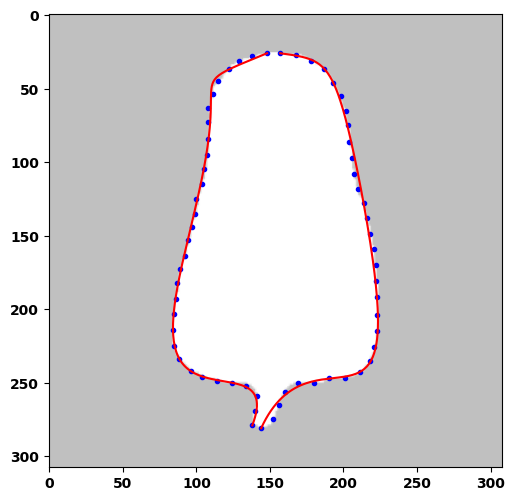

In [39]:
%%time
Demo(6,Amode=1,N=5)

# ６次 Eager

輪郭線の画素数は、左 320  右320
..........E

....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
...........................^^.......................................................................
.^....^.......................................................^..^.^.^^.............................
......................^.^.^.^^.^^^.......^^^^^...........

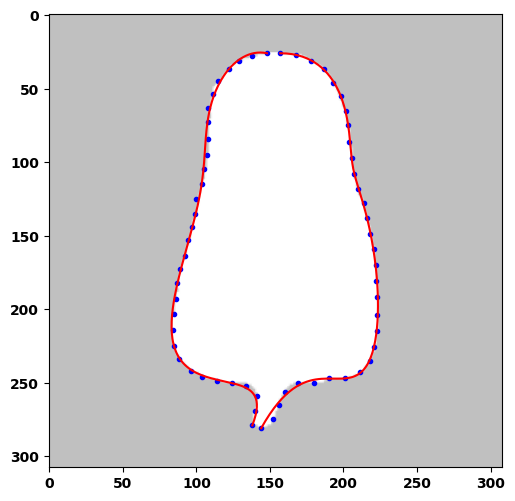

In [40]:
%%time
Demo(6,Amode=1,N=6)

# fit2() 段階的フィッティング

次数を大きく取ると、当てはめは正確になるが、同程度の誤差ならば、なるべく小さい次数で近似したい。

どれくらいの次数が適当なのかは、形状の複雑度を見ればある程度予測できるが、それを自動で行ってくれるのが fit2() である。

停止条件はサンプル点全体の当てはめ誤差の平均値であるが、デフォルトは 0.5、つまり半ピクセルに設定している。

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

3..............................^.......^...^.^...^.^^^.^.^.^.^^^.^^^.^^^^^.^^^.^.^^^.^^^.^.^.^^^^^.^^
^^^^^.^^^^^^^^^.^^^^^^^^^.^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^P

4.......................................E

0.99384584977177843.........................................................^....^^^^..^^..C

4....................................................................................................
....................................................................................................
..................................................................

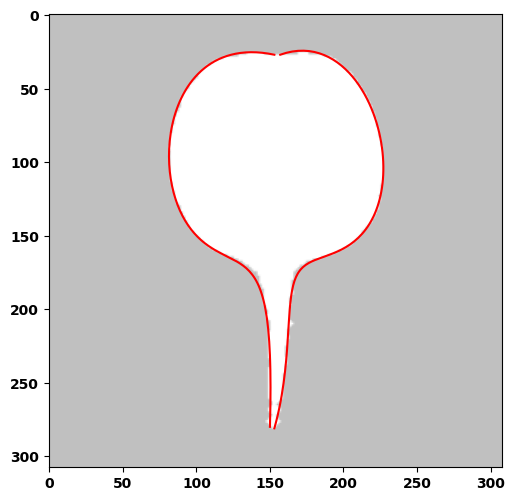

In [41]:
%%time
rd.BezierCurve.setParameters(openmode=False)
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
cntL = rd.getSamples(conLeft,N=32)
cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
bezL = rd.BezierCurve(N=5,samples=cntL)
bezR = rd.BezierCurve(N=5,samples=cntR)
# rd.BezierCurve.toggledebugmode(set=True,debug=True) # デバッグモードオン
# 段階的あてはめ
rd.BezierCurve.AsymptoticPriority = 'distance'
NL, resultsL = bezL.fit2(Nfrom=3,Nto=12,withErr=True)
NR, resultsR = bezR.fit2(Nfrom=3,Nto=12,withErr=True)
# 結果の描画
_,fL2,_ = resultsL[str(NL)]
_,fR2,_ = resultsR[str(NR)]
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL2,bezR=fR2)
print("左は{}次、右は{}次ベジエで近似".format(NL,NR))

# fit2T() 段階的フィッティング

AsymptoticPriority :  distance
dCount    :  3
debugmode :  False
openmode  :  False
wandb  :  None
convg_coe : 1e-05
swing_penalty : 0.0
smoothness_coe : 0.0

3...^................................................C

4..................E

0.82385015546213373...^^^....^....................................................C

4.......................................................C

5........................................E

0.9944742970362005左は4次、右は5次ベジエで近似
Wall time: 23.4 s


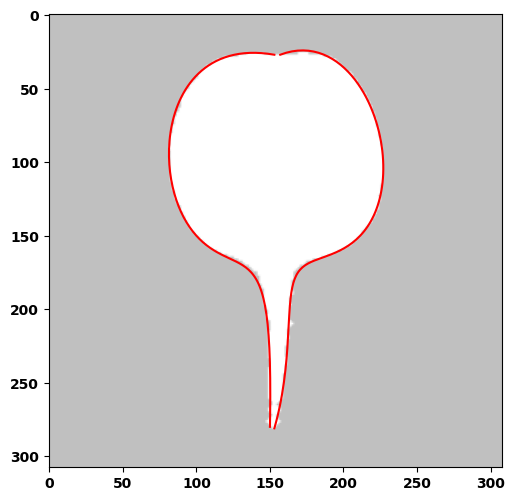

In [42]:
%%time
rd.BezierCurve.setParameters(openmode=False)
img = imgs[4]
conLeft,conRight = rd.getCntPairWithImg(img,dtopdr=1,dbtmdr=1)
# 先にもとめた左右の輪郭線からそれぞれ等間隔で32個ずつ標本点を取ってくる
cntL = rd.getSamples(conLeft,N=32)
cntR = rd.getSamples(conRight,N=32)
# ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
bezL = rd.BezierCurve(N=5,samples=cntL)
bezR = rd.BezierCurve(N=5,samples=cntR)
# rd.BezierCurve.toggledebugmode(set=True,debug=True) # デバッグモードオン
# 段階的あてはめ
NL, resultsL= bezL.fit2(Nfrom=3,mode=1,Nto=12,lr=0.005,withErr=True)
NR, resultsR = bezR.fit2(Nfrom=3,mode=1,Nto=12,lr=0.005,withErr=True)
# 結果の描画
_,fL2,_ = resultsL[str(NL)]
_,fR2,_ = resultsR[str(NR)]
rd.drawBez(img,stt=0.0,end=1.0,bezL=fL2,bezR=fR2)
print("左は{}次、右は{}次ベジエで近似".format(NL,NR))

# 重畳描画できるようにサブクラスを作ってみる

In [2]:
class MyBezierCurve(rd.BezierCurve):
    def __init__(self, N=3, samples = [], prefunc=None):
        super().__init__(N=N, samples = samples, prefunc=prefunc)
    def fit3(self,img,Nfrom=3,Nto=12, maxTry = 3000,prefunc = None,errorThres=1.0,withErr=False,tpara=[],withFig=[999]):
        cts = ["1110","2220","3330","4440","5550","6660","7770","8880","9990","0000"]
        Ncurrent = Nfrom - 1
        func = prefunc
        ts = tpara
        err = errorThres + 1
        odds = 0
        while Ncurrent < Nto and  (errorThres < err or odds>0):
            Ncurrent = Ncurrent + 1
            abez = MyBezierCurve(N=Ncurrent,samples=self.samples, prefunc = func)
            print(Ncurrent,end="")
            # 最大 maxTry 回あてはめを繰り返す
            cps,func,err = abez.fit1T(maxTry=maxTry,mode=1,withErr=True,tpara=ts)
            ts = abez.ts
            odds,_var,_dpm = rd.isOverFitting(func,ts,self.samples) 
            # 次数を上げてインスタンス生成
            if  999 in withFig or Ncurrent in withFig or Ncurrent == Nto: #  指定されている次数なら描画　ただし最後は常に描画
                rd.drawBez0(img,stt=0.00,end=1.0,bezL=func,ct=cts[(Ncurrent-3)%10],bzlabel=str(Ncurrent)) 
        if withErr:
            return cps,func,Ncurrent,err
        else:
            return cps,func

def Demo(imgnum,samples=32,Nfrom=3,Nto=5,pfL=None,pfR=None,withFig=[999],errorThres=1.0):
    img = imgs[imgnum]
    conLeft,conRight = rd.getCntPairWithImg(img) # 両サイドの輪郭を得る
    Left = rd.getSamples(conLeft,N=samples,mode='Equidistant') # 左輪郭のサンプリング
    Right = rd.getSamples(conRight,N=samples,mode='Equidistant') # 右輪郭のサンプリング 
    bezL = MyBezierCurve(N=0,samples=Left,prefunc=pfL) # 左のベジエカーブ構造体のインスタンスを生成
    bezR = MyBezierCurve(N=0,samples=Right,prefunc=pfR) # 右のベジエカーブ構造体のインスタンスを生成
    fig = plt.figure(figsize =(6, 6)) 
    cpsL,fL,NL,errorL = bezL.fit3(img=img,Nfrom=Nfrom,Nto=Nto,maxTry=10,withErr=True,prefunc=pfL,withFig=withFig,errorThres=errorThres)
    cpsR,fR,NR,errorR = bezR.fit3(img=img,Nfrom=Nfrom,Nto=Nto,maxTry=10,withErr=True,prefunc=pfR,withFig=withFig,errorThres=errorThres)
    plt.legend()
    return fL,fR,NL,NR

3..........
4..........
5..........
3..........
4..........
5..........
Wall time: 9.77 s


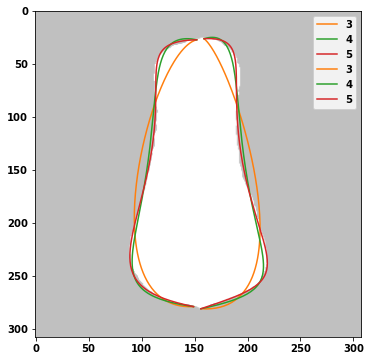

In [44]:
%%time
fL,fR,NL,NR = Demo(0,Nfrom=3,Nto=5)

3..........
4..........
5..........
3..........
4..........
5..........
Wall time: 9.45 s


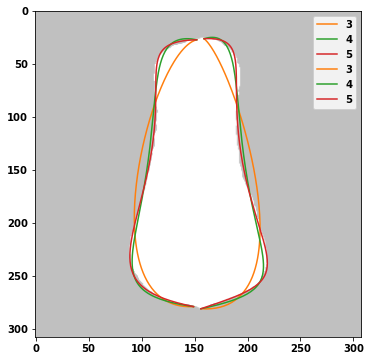

In [45]:
%%time
fLlist,fRlist=[],[]
fL,fR,NL,NR = Demo(0,Nfrom=3,Nto=5)

6.....E

6..E

Wall time: 3.95 s


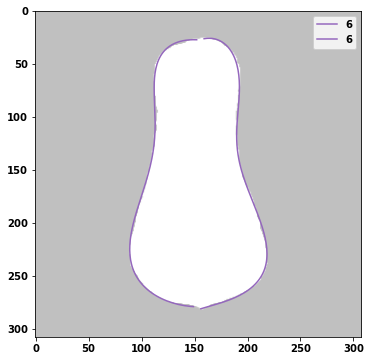

In [46]:
%%time
fL,fR,NL,NR = Demo(0,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

このダイコンは６〜８次はほとんど違わない。見た感じでは５次でも変わらない気がする。

3..........
4..........
5..........
3..........
4..........
5..........
Wall time: 9.85 s


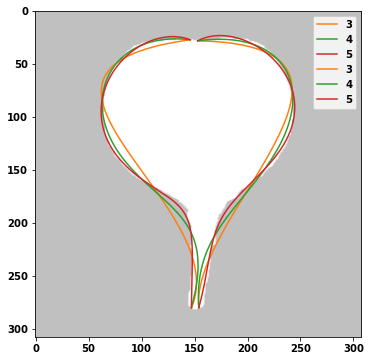

In [47]:
%%time
fL,fR,NL,NR = Demo(1,Nfrom=3,Nto=5)

6....E

6......E

Wall time: 4.68 s


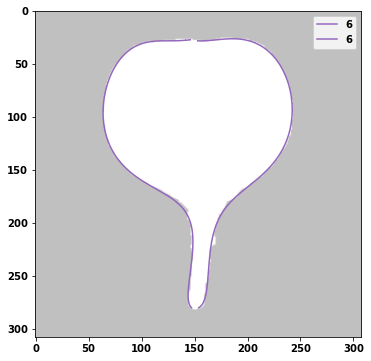

In [48]:
%%time
fL,fR,NL,NR = Demo(1,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

６次で十分

3....^.....
4..........
5.E

3..........
4.....E

Wall time: 5.49 s


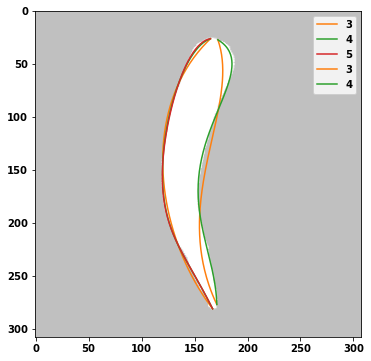

In [49]:
%%time
fL,fR,NL,NR = Demo(2,Nfrom=3,Nto=5)

6.E

6.E

Wall time: 2.8 s


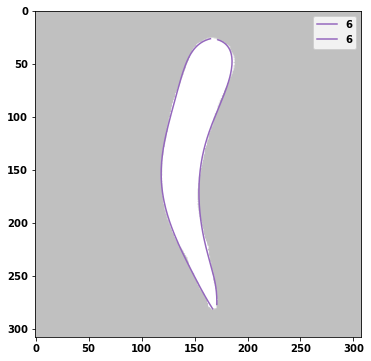

In [50]:
%%time
fL,fR,NL,NR = Demo(2,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

６次で十分

3..........
4..........E

3..........
4..E

Wall time: 4.26 s


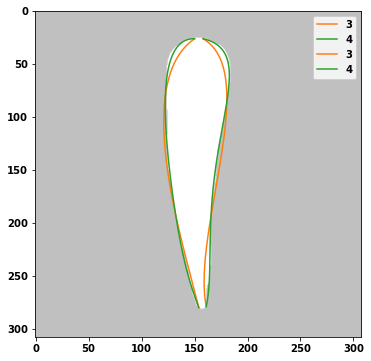

In [51]:
%%time
fL,fR,NL,NR = Demo(3,Nfrom=3,Nto=5)

6.E

6.E

Wall time: 3.02 s


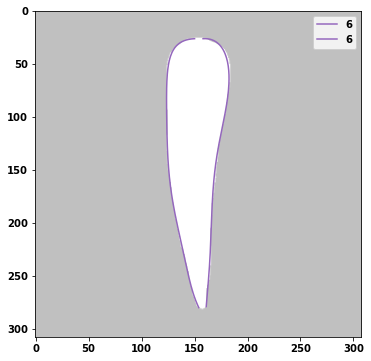

In [52]:
%%time
fL,fR,NL,NR = Demo(3,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

５次で十分

3..........
4..........
5..........
3..........
4..........
5..........
Wall time: 9.83 s


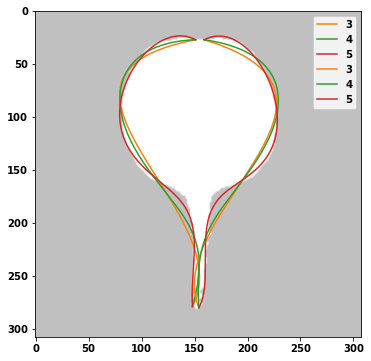

In [53]:
%%time
fL,fR,NL,NR = Demo(4,Nfrom=3,Nto=5)

6..........
7..E

6..........
7.....E

Wall time: 11.8 s


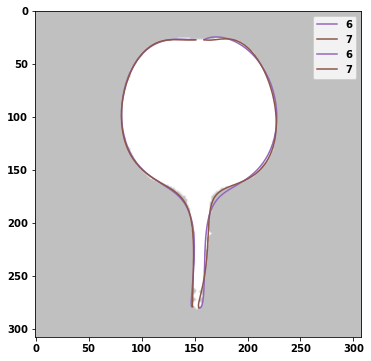

In [54]:
%%time
fL,fR,NL,NR = Demo(4,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

9...E

9..........E

Wall time: 11.2 s


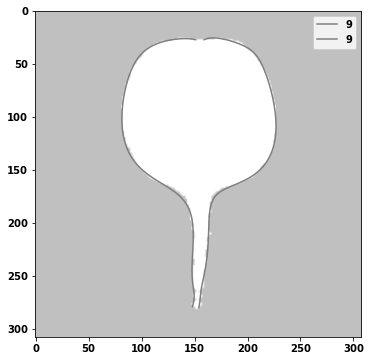

In [55]:
%%time
fL,fR,NL,NR = Demo(4,Nfrom=9,Nto=10,pfL=fL,pfR=fR)

６次以上はあまり差はないように見える。

3..........
4..........
5.........E

3..........
4..........
5..........
Wall time: 9.88 s


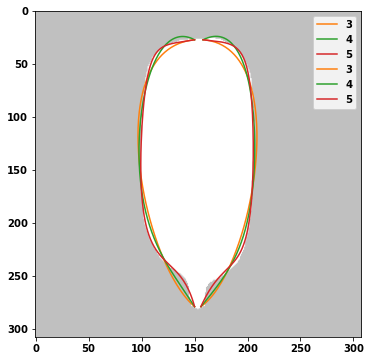

In [56]:
%%time
fL,fR,NL,NR = Demo(5,Nfrom=3,Nto=5)

6...E

6......E

Wall time: 4.37 s


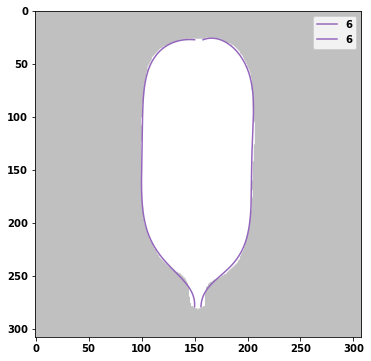

In [57]:
%%time
fL,fR,NL,NR = Demo(5,Nfrom=6,Nto=8,pfL=fL,pfR=fR)

9.E

9.E

Wall time: 5.94 s


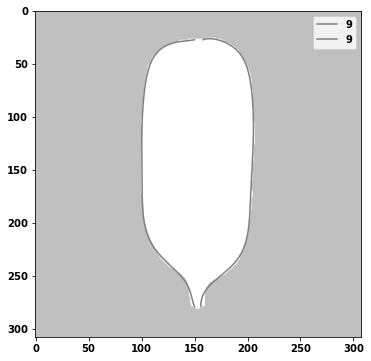

In [58]:
%%time
fL,fR,NL,NR = Demo(5,Nfrom=9,Nto=10,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

６次以上はあまり差がない

3..........
4..........
5..........
3..........
4..........
5..........
Wall time: 9.81 s


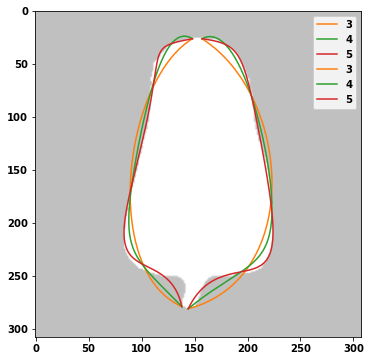

In [59]:
%%time
fL,fR,NL,NR = Demo(6,Nfrom=3,Nto=5)

6..........E

6..........
7..........
8.........E

Wall time: 16.4 s


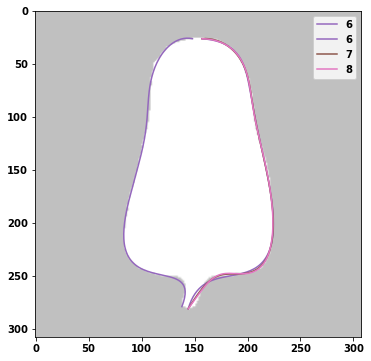

In [60]:
%%time
fL,fR,NL,NR = Demo(6,Nfrom=6,Nto=8,pfL=fL,pfR=fR)

9.E

9.E

Wall time: 6.08 s


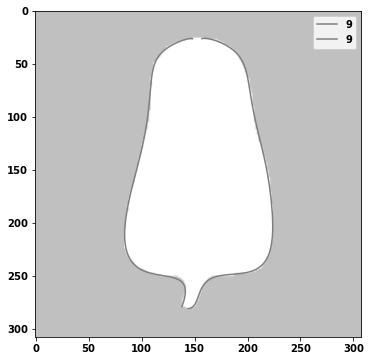

In [61]:
%%time
fL,fR,NL,NR = Demo(6,Nfrom=9,Nto=10,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

８次と９次で末端部が大きく変化したが、末端部の切り取り箇所が不適当なのと角ばり部分ができたために必要次数が上がったものであり、そこが除ければもっと低い次数で大丈夫だと思われる。

3....^.....
4..........
5..^...E

3.....^^...
4..........
5..........
Wall time: 9.18 s


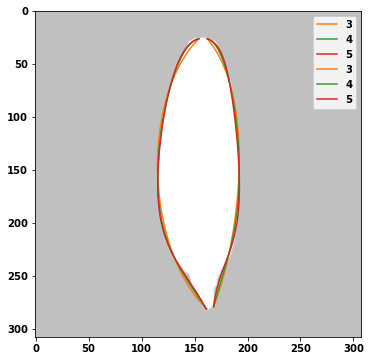

In [62]:
%%time
fL,fR,NL,NR = Demo(7,Nfrom=3,Nto=5)

6..........
7.E

6.E

Wall time: 6.59 s


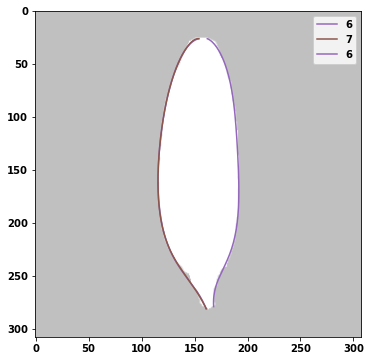

In [63]:
%%time
fL,fR,NL,NR = Demo(7,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

６次で十分である

3..........
4..........E

3..........
4..........
5....E

Wall time: 6.52 s


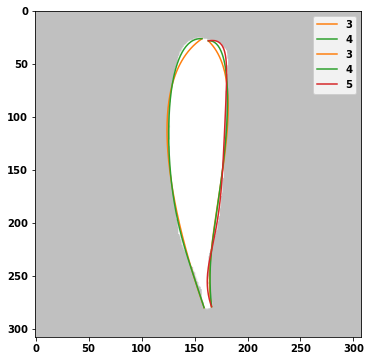

In [64]:
%%time
fL,fR,NL,NR = Demo(8,Nfrom=3,Nto=5)

6.E

6.E

Wall time: 3.06 s


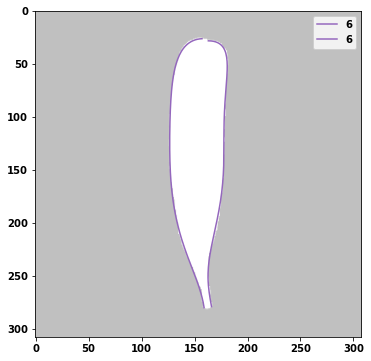

In [65]:
%%time
fL,fR,NL,NR = Demo(8,Nfrom=6,Nto=8,pfL=fL,pfR=fR)
fLlist.append(fL)
fRlist.append(fR)

６次で十分だろう

In [66]:
# 結果の保存
# フォルダ指定
labhome = COLABRDROOT if COLABORATORY else LOCALHOME
import platform
resdir = "/res/windows" if platform.system() == "Windows" else "/res"
rd.storePkl(fLlist,"fLlist.pkl",labhome+resdir) # 左側の近似曲線のリスト
rd.storePkl(fRlist,"fRlist.pkl",labhome+resdir) # 右側の近似曲線のリスト

低い次数では、尻尾の部分の形までフィッティングするのは困難である。しかし、その部分を近似することに意味はないのでかまわないだろう。

自動化の観点でいえば、問題はそういう部分を自動的にカットするのが難しいという点にある。


# 全周ベジエ近似

上端点を完全自動で求めることは、一般的には困難であるが下端は先細りであることが普通なので、自動検出もそう難しくはない。

下端点を起点かつ終点とする全周の点列を1本のベジエ曲線で近似できるかやってみる。

In [3]:
def check(imgnum,samples=65,Nfrom=3,Nto=15,mode=1,errorThres=1.0):
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=samples,mode='Equidistant')
    bez = rd.BezierCurve(N=0,samples=Samples) # インスタンス生成
    lastN,results = bez.fit2(Nfrom=Nfrom,Nto=Nto,mode=1,lr=0.001, lrP=30000, maxTry=3000, pat=300, err_th=errorThres,withErr=True)
    cps,func,err = results[str(lastN)]
    rd.drawBez(img,stt=0.0,end=1.0,bezL=func)
    print("{}次でOK".format(lastN))
    return results

def DemoAll2(imgnum,results,withFig=[999]):
    img = imgs[imgnum]
    fig = plt.figure(figsize =(6, 6)) 
    cts = ["1110","2220","3330","4440","5550","6660","7770","8880","9990","0000"]
    plt.figure(figsize=(12,6),dpi=150)
    plt.subplot(1,5,1)
    plt.imshow(192+(cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)/4).astype(np.uint8),label="silhouette")
    plt.axis('off')
    linesnum = 0
    for Ncurrent in withFig :
        cps,func,err = results[str(Ncurrent)]
        rd.drawBez(img,figsize=None,layout="15"+str(linesnum+2),stt=0.00,end=1.0,bezL=func,ct="3330",bzlabel=str(Ncurrent),linestyle=0)
        plt.legend(loc=1,prop={"size":6})
        plt.axis('off')
        linesnum +=1

3.................................................................C

4..........................................................................C

5....................................................................................................
....................................................................................................

6..............................................................C

7....................................................................................................
.............................................................E

0.9987380083650537次でOK
Wall time: 2min 58s


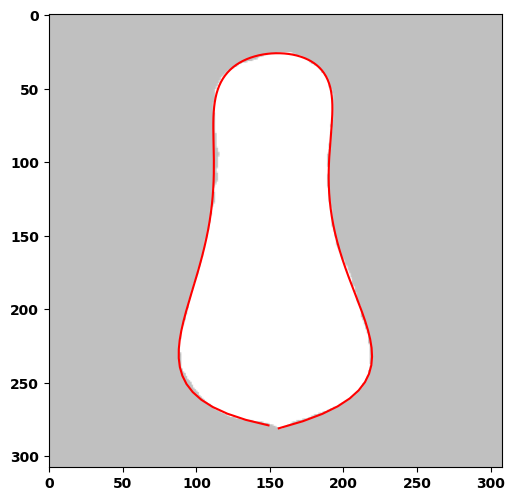

In [5]:
%%time
results = check(0,samples=65,Nfrom=6,Nto=12,errorThres=1.0)

<Figure size 432x432 with 0 Axes>

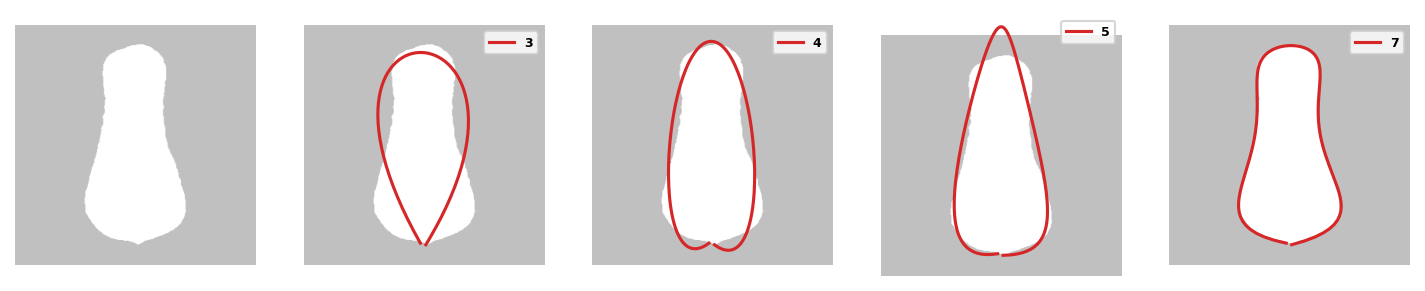

In [6]:
DemoAll2(0,results,withFig=[3,4,5,7])

3..............................................................................C

4....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..............C

5.......e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1..................................................................................
..............................................................C

6....................................................................................................
......................................................

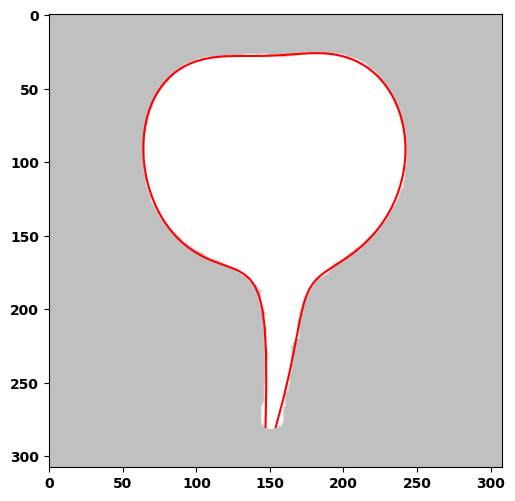

In [7]:
%%time
results1 = check(1,samples=65,Nfrom=3,Nto=15,errorThres=1.0)

<Figure size 432x432 with 0 Axes>

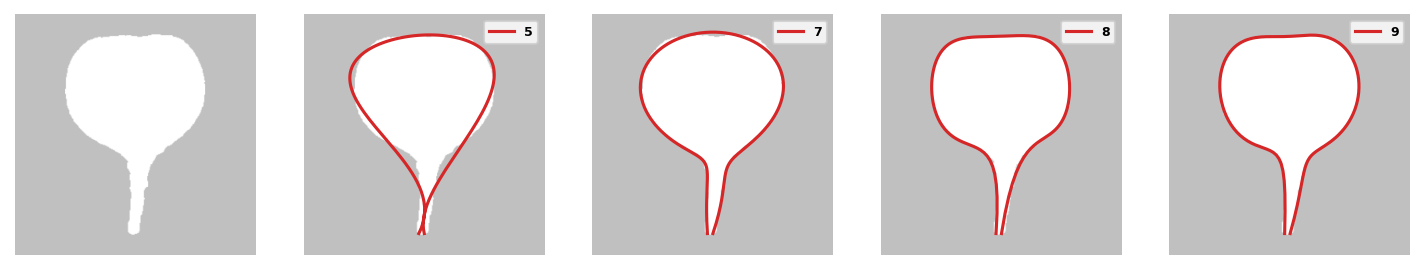

In [8]:
DemoAll2(1,results1,withFig=[5,7,8,9])

3....................................................................................................
....................................................................................................

4....................................................................................................
....................................................................................................

5....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
......................................................................................

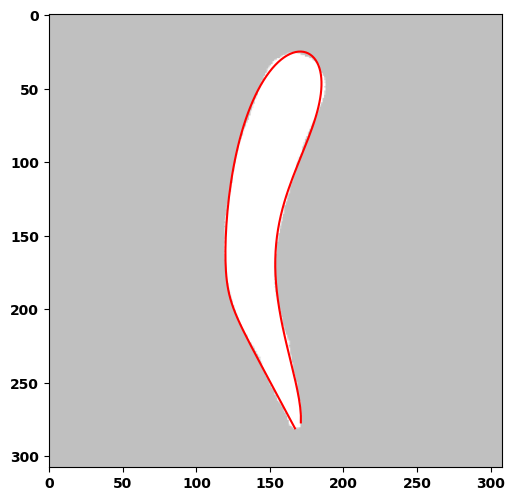

In [9]:
%%time
results2 = check(2,samples=65,Nfrom=5,Nto=12,errorThres=1.0)

<Figure size 432x432 with 0 Axes>

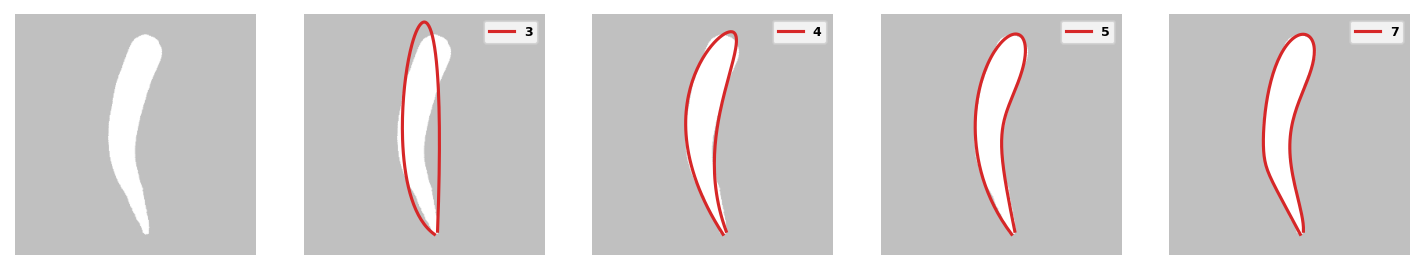

In [10]:
DemoAll2(2,results2,withFig=[3,4,5,7])

3....................................................................................................
....................................................................................................
....................................................................................................
................C

4....................................................................................................
....................................................................................................
....................................................................................................
..........................................................^.........................................
.................................^^^^.^.............^^.^...........................................^
^^.^^..^.^^..^.^^..^.......................^^^..^.^^^.^^^.^^^^..^..^...................^^^^^.^.^^^^^
^^^^^^.^.^...^.^..C

5................................................

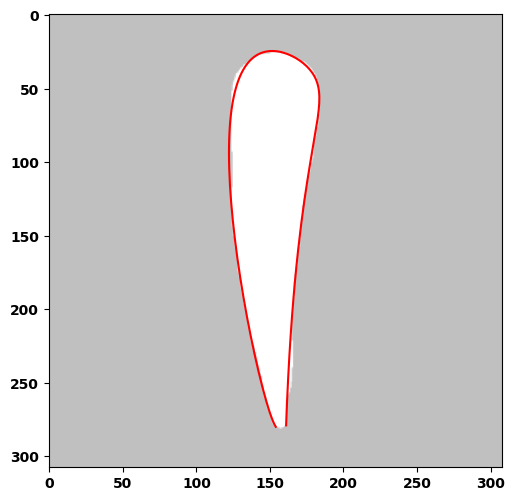

In [11]:
%%time
results3 = check(3,samples=65,Nfrom=3,Nto=7,errorThres=1.0)

<Figure size 432x432 with 0 Axes>

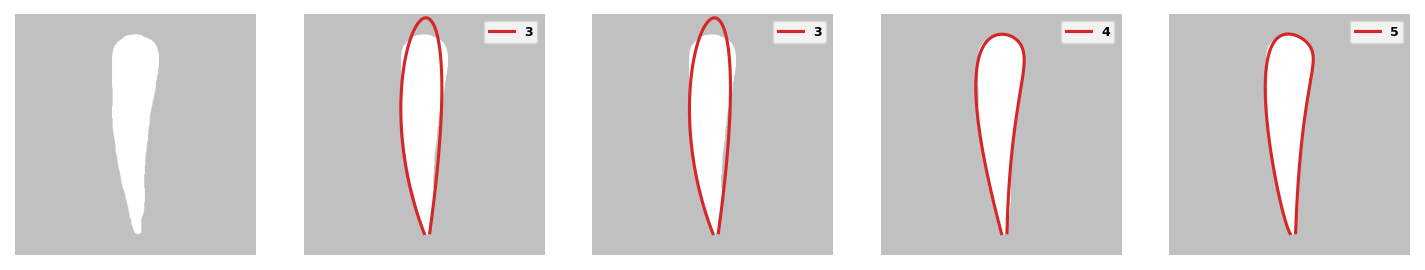

In [12]:
DemoAll2(3,results3,withFig=[3,3,4,5])

3....................................................................................C

4....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..................................................................................C

5....................................................................................................
..................................................................................................C

6................

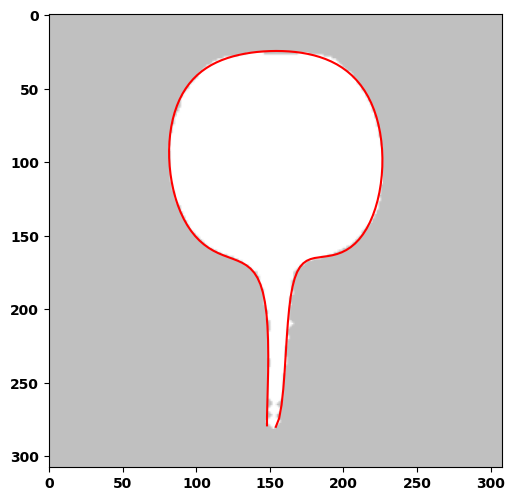

In [4]:
%%time
results4 = check(4,samples=65,Nfrom=3,Nto=15,errorThres=1.0)

<Figure size 432x432 with 0 Axes>

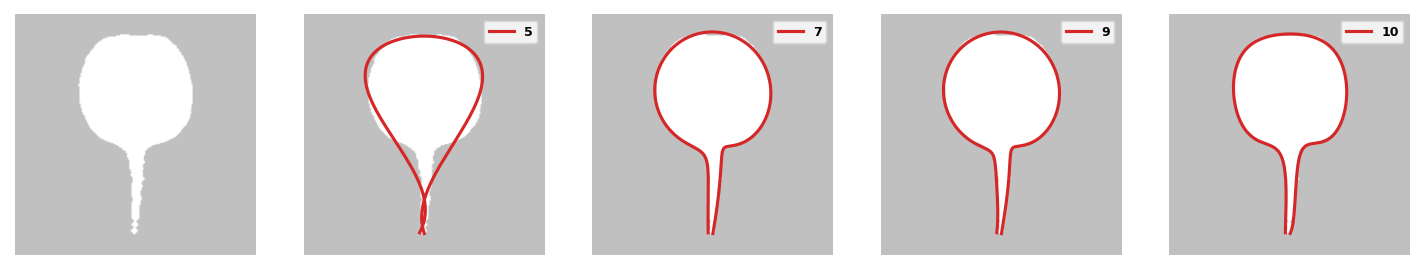

In [5]:
DemoAll2(4,results4,withFig=[5,7,9,10])

3....................................................................................................
.........C

4....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.......................................................................C

5...........^^.......................................................................................
....................................................................................................
....................................................................................................
..

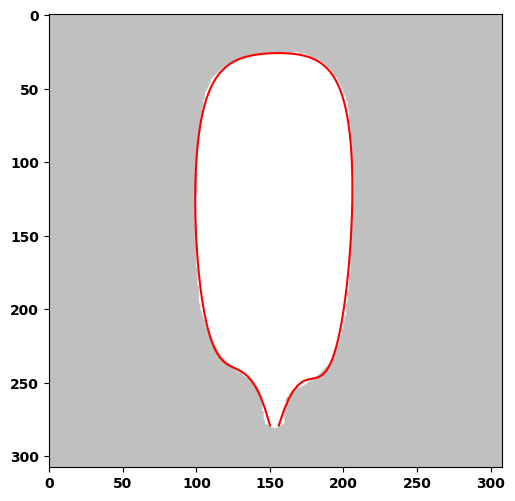

In [4]:
%%time
results5 = check(5,samples=65,Nfrom=3,Nto=15,errorThres=1)

<Figure size 432x432 with 0 Axes>

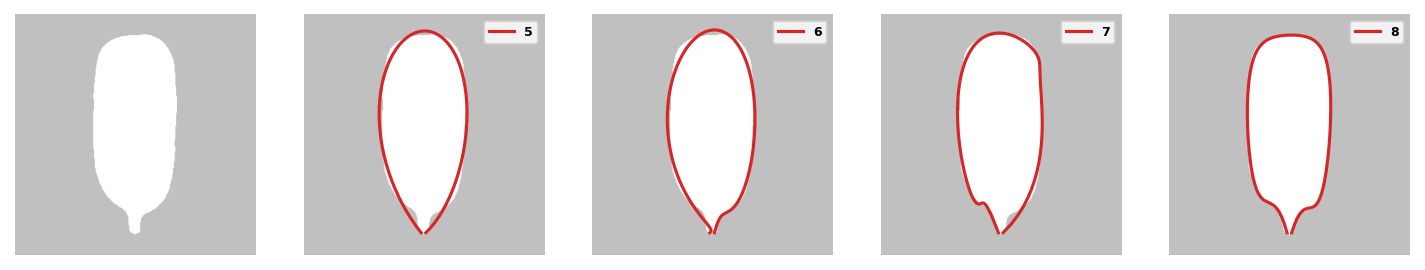

In [5]:
DemoAll2(5,results5,withFig=[5,6,7,8])

3....................................................................................................
....................................................................................C

4.....e1e1e1.e1e1e1.e1e1e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e3e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e1e1e1.e1e1e1.e1e1e1.e1.................................C

5..e1e1.e1e1e1.e1e1e1.e1e1e1.e1e1e1.e1e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e2e2e2.e1e1e1.e1e1e1.e1e1e1..........................................
....................................................................................................
...................................

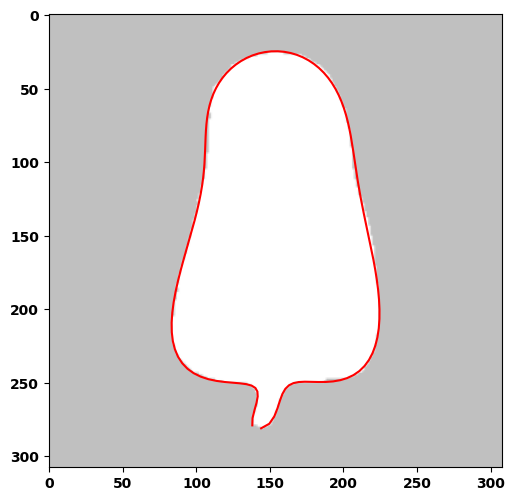

In [6]:
%%time
results6 = check(6,samples=65,Nfrom=3,Nto=15,errorThres=1)

<Figure size 432x432 with 0 Axes>

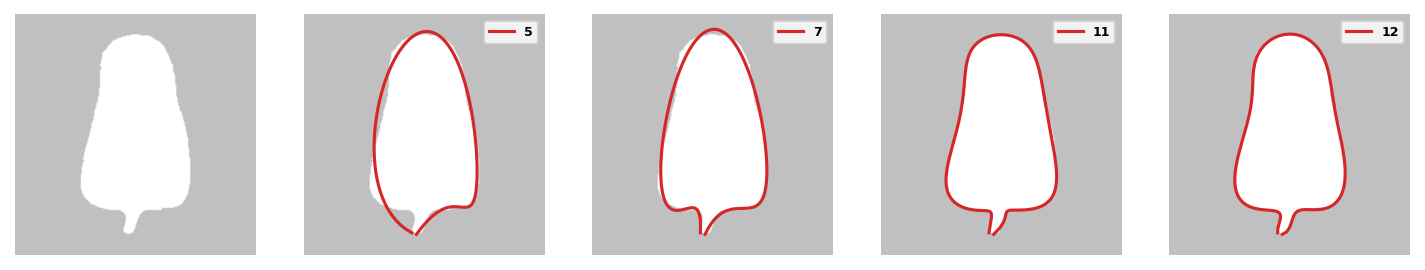

In [24]:
DemoAll2(6,results6,withFig=[5,7,11,12])

3....................................................................................................
....................................................................................................
...................................................................C

4....................................................................................................
.......................C

5....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.............................................................................................

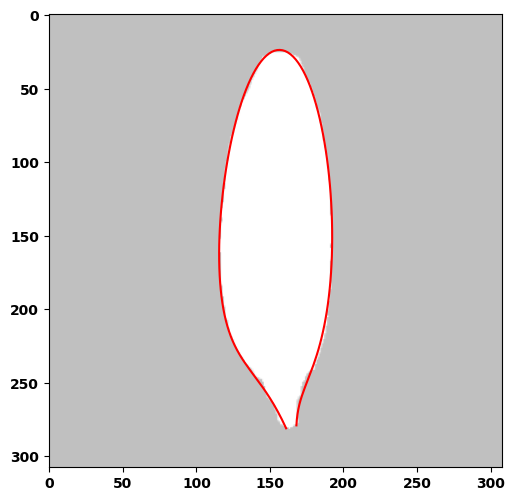

In [8]:
%%time
results7 = check(7,samples=65,Nfrom=3,Nto=15,errorThres=1)

<Figure size 432x432 with 0 Axes>

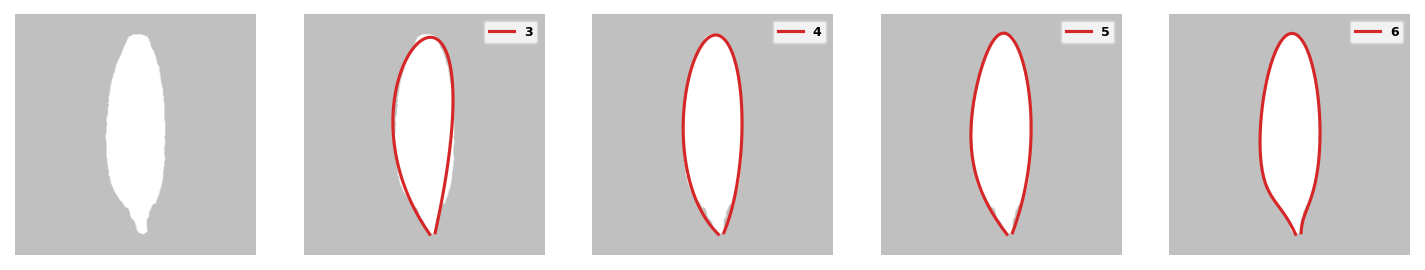

In [9]:
DemoAll2(7,results7,withFig=[3,4,5,6])

3....................................................................................................
....................................................................................................
....................................................................................................
............^..C

4....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
.......................................................................

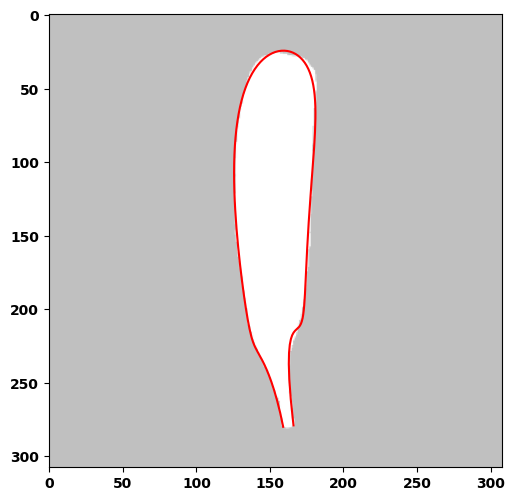

In [11]:
%%time
results8 = check(8,samples=65,Nfrom=3,Nto=15,errorThres=1.)

<Figure size 432x432 with 0 Axes>

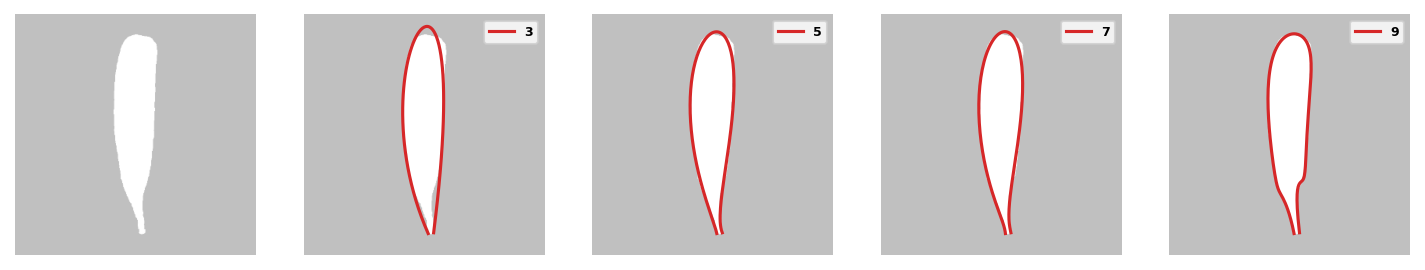

In [12]:
DemoAll2(8,results8,withFig=[3,5,7,9])

In [5]:
def DemoAll(imgnum,samples=64,Nfrom=6,Nto=15,pf=None,draw=[],withFig=[999]):
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1)  # 全周輪郭を得る
    print("輪郭線の画素数は、{}".format(len(conAll)))
    Samples = rd.getSamples(conAll,N=samples,mode='Equidistant')
    # ベジエ曲線の近似次数（N)とサンプルをセットしてベジエ曲線のインスタンスを作成
    bez = MyBezierCurve(N=0,samples=Samples,prefunc=pf) # インスタンス生成
    fig = plt.figure(figsize =(6, 6)) 
    cps,fall,N,error = bez.fit3(img=img,Nfrom=Nfrom,Nto=Nto,maxTry=3000,withErr=True,prefunc=pf,withFig=withFig)
    plt.legend()
    print("必要次数は",N)
    return fall,N

輪郭線の画素数は、609
11...........................E

必要次数は 11
Wall time: 20.2 s


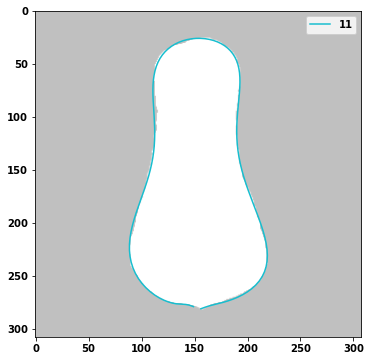

In [99]:
%%time
fall=[]
fl,N = DemoAll(0,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、658
11...^................................................................................................
....................................................................................................
........E

必要次数は 11
Wall time: 2min 21s


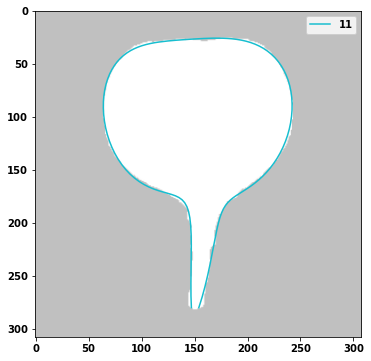

In [100]:
%%time
fl,N = DemoAll(1,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、526
11...............................E

必要次数は 11
Wall time: 23.1 s


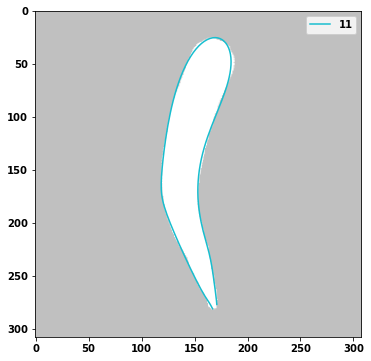

In [101]:
%%time
fl,N = DemoAll(2,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、536
11...........................................E

必要次数は 11
Wall time: 31.5 s


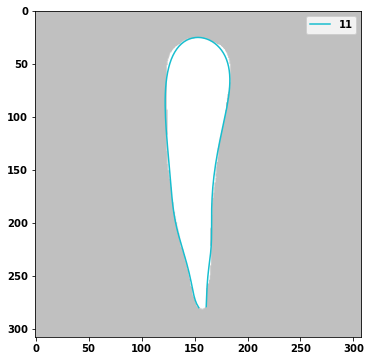

In [102]:
%%time
fl,N = DemoAll(3,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、644
11....................................................................................................
....................................................................................................
....................................................................................................
............................................................^^......................................
....................................................................................................
....................................................................................................
....................................................................................................
..................................E

必要次数は 11
Wall time: 8min 12s


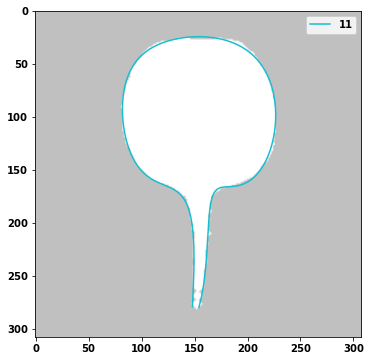

In [103]:
%%time
fl,N = DemoAll(4,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、571
11....................E

必要次数は 11
Wall time: 15.7 s


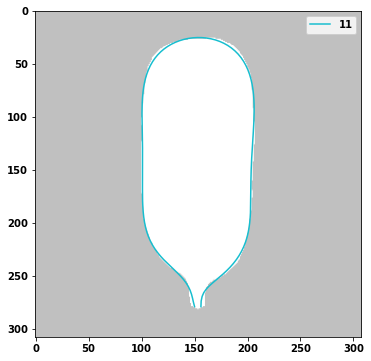

In [104]:
%%time
fl,N = DemoAll(5,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、631
11.....................................................E

必要次数は 11
Wall time: 38.1 s


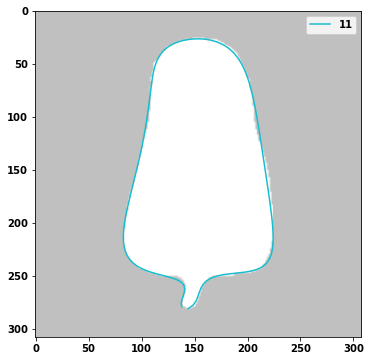

In [105]:
%%time
fl,N = DemoAll(6,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、532
11.......E

必要次数は 11
Wall time: 7.09 s


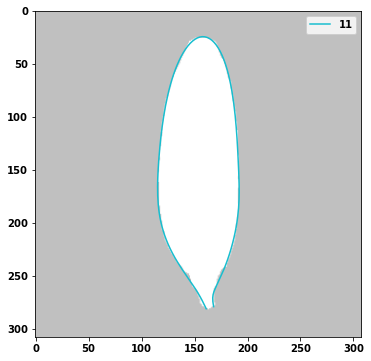

In [106]:
%%time
fl,N = DemoAll(7,samples=31,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

輪郭線の画素数は、531
11.......................................................E

必要次数は 11
Wall time: 1min 10s


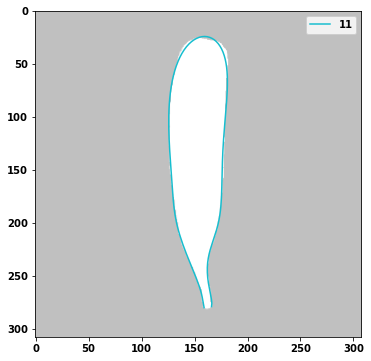

In [107]:
%%time
fl,N = DemoAll(8,samples=64,Nfrom=11,Nto=11,pf=None,withFig=[11])
fall.append(fl)

In [108]:
# 結果の保存
labhome = COLABRDROOT if COLABORATORY else LOCALHOME
resdir = "/res/windows" if platform.system() == "Windows" else "/res"
rd.storePkl(fall,"fall.pkl",labhome+resdir) 

# まとめ

- ほとんどの個体の両側は、６次ベジエ曲線まででかなりいい線の近似が可能である。

- 全周を１本のベジエ曲線で近似することも可能である。その場合は、12か13次ぐらいの次数が必要である。
- 根の細い部分は形状が複雑で多様なので、その部分も正確に近似するのは難しい。
  次数を高く設定すれば近似できるが、そのような部分を捉えることにはあまり意味がないので、予めカットして主要部のみを対象とすることが望ましい。自動処理を重視するならば、一旦粗く近似して後述の中心軸の近似を行った後に幅を基準にカットし、再近似する（２pass）などの解決を図ればよい。

# オーバーフィッティングの対策と判定
標本点を使った曲線あてはめでは、オーバーフィッティング、すなわち標本点以外の部分で曲線が実際とずれるという状況の発生が避けなれない。経験的にも、直感的にも、次数が必要十分な数の前後で発生しがちである。必要十分な十分大きい場合はほとんど発生しないし、十分少なければ標本点間だけでなく標本点でもずれるのでオーバーフィッティングとは言えない（アンダーフィッティング）。ずれが大きいと、これはオーバーフィッティングだと気づくが、きれいにフィッティングできているように見える場合でも標本点間が完璧にフィットするということはない。したがって、あてはめ誤差とは別にオーバフィッティングを判定する客観基準を設ける必要がある。

## オーバーフィッテイングの判定基準
対応点のずれは単純に距離で測ればよいし、区分曲線同士のずれの尺度は点同士ほど単純ではない。輪郭を構成する各点と近似曲線との距離の合計でよいのでは、と思うかもしれないが、それは標本点間隔を短くしたのと同じであり、近似曲線は離散的な輪郭点のすべての近くを通りつつ輪郭から離れた軌跡を描くことがありうる。

ここでは、輪郭点とのずれそのものを測るのはあきらめ、近似曲線上にとられた標本点の対応点間の道のりの長さが均一かどうかで間接的にずれを判定するものとする。

近似曲線は高次の連続関数なので道のりは数値計算的に求めざるをえない。あまり精度を上げても無駄に計算時間がかかるだけなので、各区間をパラメータ上で４区間に当分割して折れ線近似し、折れ線の長さで道のりを近似する。

よく使われる、４分位点を基準とした外れ値判定（第１四分位点と第３四分位点から四分位範囲の1.5倍の値を判定基準にする方法）をこころみたところ、1.5倍では目視できれいにフィッティングしているのにオーバフィッティングを判定されてしまう例が発生することがわかった。その方法の場合、アドホックになるが、1.3倍程度を基準とするとよいかもしれない。

次に、スミルノフ・グラブス検定スミルノフ・グラブス検定による外れ値判定を試してみたところ、有意基準を上下30％程度に設定するとよさそうだということがわかった。

## オーバフィッティング対策
標本点を増やすのが一番簡単であるが、標本点の数を増やすと計算時間がかかってしまう。

勾配法の場合は正則化項を追加するという方法が考えられる。
- 近似曲線の接線方向と標本点間を結ぶ直線の方向ベクトルの差ベクトルの長さの平均値
- 近似曲線上の区分点における２次微係数の平均値
などを正則化項として考えてみた。それぞれそれなりに機能したが効果は個別的であった。

オーバーフィッティングが生じやすいのは、
1. 端点付近
2. 変曲点、特に肥大部と根の境界
であり、特に多いのが端点部分である。

計算量をそれほど増やさずにオーバフィッティングを抑える方法として、オーバーフィッティングが生じやすい箇所だけピンポイントに標本点を追加するという方法が考えられる。残念ながら変曲点の位置を自動判定するのは困難であるが、端点付近なら場所が決まっているので対応可能である。

そこで各フィッティング関数に、moption というオプションを追加し、
- moption = False -> オーバフィッティング対策なし
- moption = True -> 端点とそれに隣接する標本点の中点をフィッティング対象として追加
とした。






In [212]:
# OverFitting判定　標本点間の異常判定
import scipy.stats as stats

# スミルノフ・グラブス検定で３０％基準、かつ４分位範囲の１．５倍基準の両方ではずれ値と判定される区間を含む場合にオーバフィッティングと判定する。
def isOverFitting(func,ts,Samples,alpha=0.3):
    t = symbols('t')
    fx,fy = func
    nfx, nfy = lambdify(t, fx, "numpy"), lambdify(t, fy, "numpy")
    rs = []
    for i in range(len(ts)-1):
        d5 = np.linspace(ts[i],ts[i+1],5)  # 標本点のパラメタ間を4分割
        d5x = np.array([nfx(s) for s in d5])  # 区分点のｘ座標
        d5y = np.array([nfy(s) for s in d5])  # 区分点のｙ座標
        r4x = d5x[1:]-d5x[0:-1]  # 隣接区分点のｘ変位
        r4y = d5y[1:]-d5y[0:-1]  # 同ｙ変位
        r = np.sum(np.sqrt(r4x*r4x + r4y*r4y)) # 折れ線の長さの合計 
        rs.append(r)
    # rs = np.array(rs)
    # 本来ｒはどの標本間でも一致すべき 
    q1,q3 = np.percentile(rs, q=[25, 75]) # 第１第３の四分位点
    odds = np.where((rs>q3+1.5*(q3-q1))|(rs<q1-1.5*(q3-q1))) # 異常値のインデックス
    odds2 = []
    rs2 = rs.copy()
    for r in sorted(odds[0], reverse=True):
        std = np.std(rs2, ddof=1) # 標準偏差
        myu = np.mean(rs2) # 平均値
        # スミルノフ・グラブス検定の基準でも外れ値であることをテスト
        n = len(rs2)
        t = stats.t.isf(q=(alpha / n) / 2, df=n - 2) # 有意基準
        tau = (n - 1) * t / np.sqrt(n * (n - 2) + n * t * t) # スミルノフ・グラブス検定の有意点
        tau_far = np.abs((rs2[r] - myu) / std) # はずれ度
        if tau_far > tau: # はずれ度が高い場合
            odds2.append(r)
            rs2 = rs2[:r]+rs2[r+1:]
        else:
            break
    return odds2,rs

def smirnov_grubbs(data, alpha=0.3):
    x, o = list(data), []
    while True:
        n = len(x)
        t = stats.t.isf(q=(alpha / n) / 2, df=n - 2)
        tau = (n - 1) * t / np.sqrt(n * (n - 2) + n * t * t)
        i_min, i_max = np.argmin(x), np.argmax(x)
        myu, std = np.mean(x), np.std(x, ddof=1)
        i_far = i_max if np.abs(x[i_max] - myu) > np.abs(x[i_min] - myu) else i_min
        tau_far = np.abs((x[i_far] - myu) / std)
        if tau_far < tau: break
        o.append(x.pop(i_far))
    return (np.array(x), np.array(o))

def ovtest(imgnum,N,maxTry,pat,moption=True,snum=65,alpha=0.3):
    img = imgs[imgnum]
    conAll = rd.getCntPairWithImg(img, mode=1) # 全周輪郭を得る
    Samples = rd.getSamples(conAll,N=snum,mode='Equidistant')
    bez = rd.BezierCurve(N=N,samples=Samples) # インスタンス生成
    cps, func, (minerror,trynum) = bez.fit1T(mode=1, maxTry=maxTry, withErr=True, withEC=True,prefunc=None,tpara=[], lr=0,  lrP=0, pat=pat, err_th=1.0, threstune=1.00, trial=None, scatter=False, moption=moption)
    odds,rs = isOverFitting(func,bez.ts,bez.samples,alpha=alpha) 
    rd.drawBez0(img,stt=0.00,end=1.0,bezL=func,cntL=Samples) 
    return odds,rs


....................................................................................................



[57, 4]

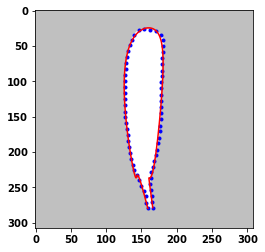

In [209]:
odds,rs = ovtest(8,8,100,100,snum=65,moption=True)
odds

.......................................................E



[]

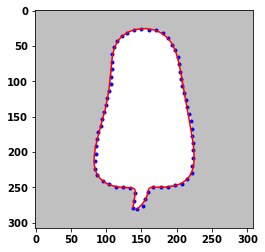

In [217]:
odds,rs = ovtest(6,11,100,100,snum=65,moption=True,alpha=0.3)
odds

....................................................................E



[58, 57]

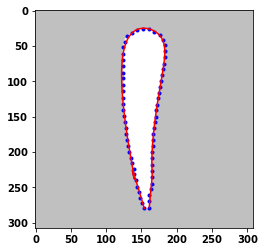

In [218]:
odds,rs = ovtest(3,8,100,100,snum=65,moption=True,alpha=0.3)
odds

.^^..^^.......^..^.......^..^.......................................................................



[]

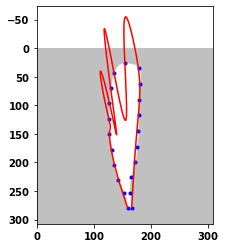

In [222]:
odds,rs = ovtest(8,11,100,100,snum=21,moption=False)
odds

残念ながら、このように明らかにオーバフィッティングしていても、外れ値基準ではオーバフィッティングだと判定できない。 

端部標本点追加の効果

.............^......................................................................................

[ 24.76022741  25.60391174  30.48166599  31.33736145  32.8896298
  31.34633358  51.54397928  70.90311801  66.74587129  34.66193297
  32.38391759 179.92478709 241.20741785  32.72344763  33.67538852
  35.16099128  30.1984988   28.93040879  28.89747749  28.91749169]


(4, (array([ 7,  8, 11, 12], dtype=int64),))

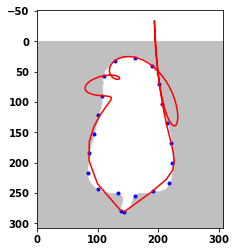

In [47]:
ovtest(6,11,100,100,False) # オプションなし

............................................E

[34.99895932 32.42374234 34.15746348 33.15607451 32.01651298 31.8149097
 32.71252412 32.92072538 31.67224371 33.77265487 32.30840271 32.32674182
 33.29219808 32.06935294 33.62487283 34.00091669 34.12935659 30.63638792
 30.9755079  33.92998667]


(0, (array([], dtype=int64),))

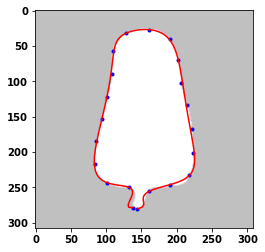

In [49]:
ovtest(6,11,100,100,True) # オプションあり

..^^..^^..^.........................................................................................

[  34.23102325   36.97113717   30.8349319    34.1202227    35.21291932
   36.16119021   35.48682806 1755.58136998  815.38216306  597.68355164
  565.0554923   485.03183852  200.83572072  128.74070977   33.34187291
   34.32992117   32.0673848    33.29199968   33.3689695    35.20016464]


(2, (array([7, 8], dtype=int64),))

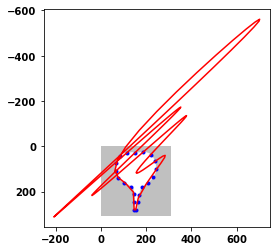

In [50]:
ovtest(1,11,100,100,snum=21,moption=False) # オプションなし

..........^.........................................................................................

[32.9887556  33.96613711 31.26077646 33.39448358 33.90730998 32.68223309
 35.18629041 33.89139883 33.06826566 33.17969154 34.93361632 33.97357884
 32.86174412 33.41075519 33.87441654 35.52836006 34.31904374 30.84130666
 31.25345426 32.83028234 32.3212362 ]


(1, (array([17], dtype=int64),))

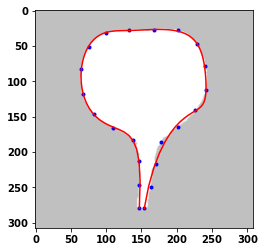

In [60]:
ovtest(1,11,100,100,snum=22,moption=False) # オプションなし

e1......^^............................................................................................

[31.03783876 33.29785344 29.72856205 32.20161081 31.34693943 33.66126793
 32.34991502 32.66138817 31.33794169 30.95888337 33.23959033 32.02451353
 32.85856766 33.35489445 31.03474346 51.94753077 30.31668376 31.79695589
 28.6470173  30.6542629  31.72405365 30.3697184 ]


(1, (array([15], dtype=int64),))

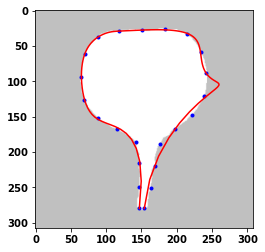

In [59]:
ovtest(1,11,100,100,snum=23,moption=False) # オプションなし

..^^..^^.......................^.................................................^^^^...............
...............^^^^.^^^^^^^^^^..........C

[ 38.11753129  33.7572257   30.99839326  30.47117482  34.22366703
  34.26470924  27.57574131 824.47965205 453.91323659 142.00564445
 359.81506234 551.75256547  34.49457881  34.87727978  36.98969973
  34.67374349  33.3186776   33.73693127  33.93436059  34.2112906 ]


(5, (array([ 7,  8,  9, 10, 11], dtype=int64),))

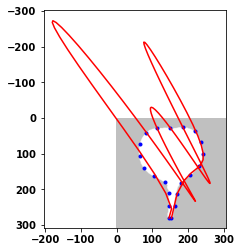

In [66]:
ovtest(1,10,300,100,snum=21,moption=False) # オプションなし

....................................................................................................

[34.02457726 36.01795755 38.62657223 35.89520921 35.41301451 34.86191137
 35.82147556 35.88818063 31.99347159 36.98661431 34.960724   35.37194093
 35.73186316 35.94725182 34.48757441 34.57483814 34.74231701 37.91845923
 33.75271486 34.23333773]


(2, (array([2, 8], dtype=int64),))

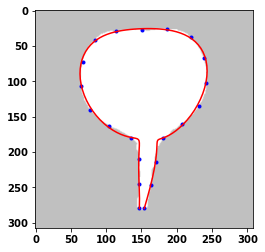

In [51]:
ovtest(1,11,100,100,True) # オプションあり

e2e2e2.e2e2e2.e1e1e1..e1^..^..^^.^.........................^^...........................................................

[  31.00819071   33.98818324   31.78410804   33.59692223   33.61773486
   32.94843365 1243.20762604  716.9758712   788.79991085  990.5714602
 1762.32427318   31.04001729   33.40340985   37.92544307   31.27265239
   31.96556847   28.45128664   27.41797911   33.65107094   30.34826388]


(5, (array([ 6,  7,  8,  9, 10], dtype=int64),))

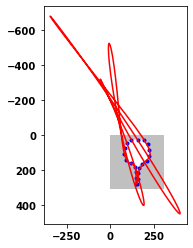

In [52]:
ovtest(4,11,100,100,False) # オプションなし

...^^...............................................................................................

[31.02866555 34.09628191 32.22013576 32.45023964 32.57119158 32.79856877
 35.78121885 32.79553312 31.20371711 35.48289509 34.89168859 31.24630523
 34.3611322  36.42400314 31.80181173 33.43195618 30.52768026 28.30115866
 33.15805971 30.56901753]


(0, (array([], dtype=int64),))

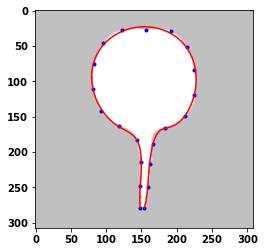

In [53]:
ovtest(4,11,100,100,True) # オプションあり

....................................................................................................

[67.97000619 16.89476039 16.1101086  17.90020747 15.1827847  16.53300973
 16.94581973 16.65743313 17.02611234 16.36913546 16.44811943 16.39009447
 17.97154229 17.19153947 17.36470012 15.67093683 15.77405254 15.7075669
 17.94867574 17.38431292 18.14566518 16.7183134  15.84112154 15.53512172
 17.64482012 16.77477359 18.26049208 18.04376442 15.93490692 15.99989328
 17.44307559 16.5243773  18.53781617 16.31055845 14.26382015 14.01776166
 15.91194303 17.24084062 16.22733762 39.1841988 ]


(2, (array([ 0, 39], dtype=int64),))

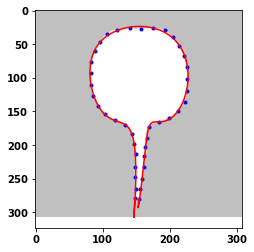

In [56]:
ovtest(4,11,100,100,snum=41,moption=False) # オプションなし

.......................................................E

[10.17531841 11.03024917 12.06962921 10.04130489 10.07955653 10.48539621
 10.33633126 11.15773481  9.32149881 11.01691749 10.22845737 11.13750586
  9.99875305 10.17547526  9.4839153  10.19752268 10.47264152 10.43730182
  9.05185991 10.36666607 10.26046207  9.91449673 11.03620261 10.96120574
  9.81268365 10.25147484 10.09069095  9.06704428  9.34149159 10.52130769
 10.33265675 11.19605129  9.71004834 10.06298725  9.75602974 10.95095753
  9.40307597 10.68243728  9.92743975 11.01932674 10.21862205 10.04887513
 10.37004611  9.38174353 10.22694327 10.38962117 10.22168472 11.00785719
 10.02869988 11.04461327  9.98898583 11.14520449 11.33814752  9.99242163
 10.69821852  8.93135116  9.96681627 10.28842688 10.07864988 10.98322967
 11.91727971 10.02149284  9.84375273  9.02463798]


(1, (array([2], dtype=int64),))

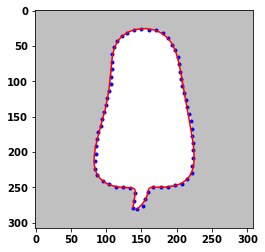

In [69]:
ovtest(6,11,100,100,snum=65,moption=True) 

# 解説は[こちら](https://colab.research.google.com/gist/iciromaco/a39fad822382b65eda0ec6a2e61981cb/s6_-theory-commentary-fitting-beziercurve-to-sample-points.ipynb)

# 備考

## 曲線あてはめの評価尺度について

曲線あてはめに使うあてはめ誤差としては、通常は曲線と標本点の最短距離を用いるのが妥当であろう。
このノートの実験にもその尺度を用いた。

```'rd.BezierCurve.AsymptoticPriority = 'distance'```

は、その尺度を用いるということの宣言である。

これ以外の尺度として、**'span'** を用意した。

**span**を指定した場合は、標本点が等間隔であるということを前提として、標本点と曲線上の最寄り点との距離の代わりに、曲線上に等間隔に採った点との距離を評価尺度とする。

例として、

```
[[100,100],[100,120],[100,140],[100,160],[100,180],[120,180],[140,180],[160,180],[180,180]]
```

という点列を使って結果を比べてみよう、

### distance

....................................................................................................
...............................................................................................C



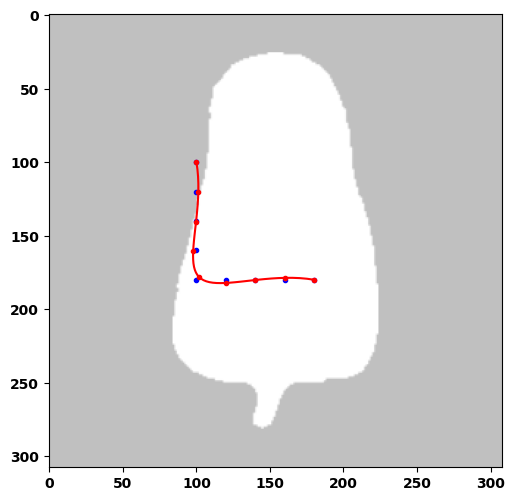

In [65]:
rd.BezierCurve.debugmode = False
test = np.array([[100,100],[100,120],[100,140],[100,160],[100,180],[120,180],[140,180],[160,180],[180,180]])
rd.BezierCurve.AsymptoticPriority = 'distance'
bez = rd.BezierCurve(N=4,samples=test)
cps,f = bez.fit1()
#cps,f = bez.fit0(bez.ts)
rd.drawBez(img,stt=0.00,end=1.0,bezL=f,cntL=test[::-1])
tl = bez.ts
flx,fly = f
setlx = [float(flx.subs('t',s)) for s in tl]
setly = [float(fly.subs('t',s)) for s in tl]
plt.scatter(setlx,setly,marker='.',color='red')

### span

.....^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
^^^^^^P



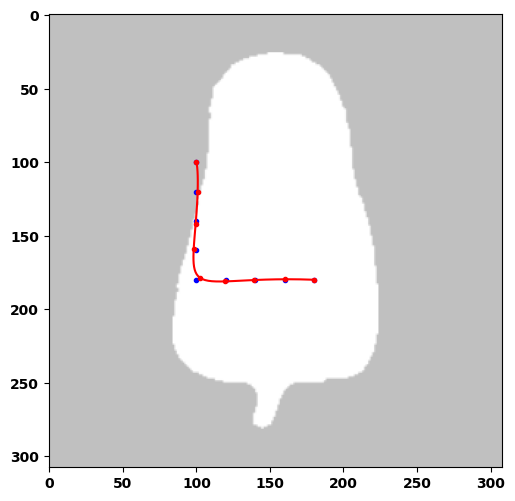

In [66]:
rd.BezierCurve.debugmode = False
test = np.array([[100,100],[100,120],[100,140],[100,160],[100,180],[120,180],[140,180],[160,180],[180,180]])
rd.BezierCurve.AsymptoticPriority = 'span'
bez = rd.BezierCurve(N=4,samples=test)
cps,f = bez.fit1()
#cps,f = bez.fit0(bez.ts)
rd.drawBez(img,stt=0.00,end=1.0,bezL=f,cntL=test[::-1])
tl = bez.ts
flx,fly = f
setlx = [float(flx.subs('t',s)) for s in tl]
setly = [float(fly.subs('t',s)) for s in tl]
plt.scatter(setlx,setly,marker='.',color='red')

この例では明らかに span の方があてはめ精度が高い。

ただダイコンのシルエットをいくつか試した限りでは、span は大きな歪を生じることが多かった。